# 🎵 VAE for Hybrid Language Music Clustering

**Course:** Neural Networks  
**Dataset:** 4MuLA Tiny (1,988 songs, 93 artists, 27 genres)  
**Languages:** English, Portuguese, Spanish

---

## Project Overview

This notebook implements an unsupervised learning pipeline using Variational Autoencoders (VAE) for clustering multilingual music tracks. We extract latent representations from audio features (melspectrograms) and lyrics, then perform clustering analysis.

### Tasks Covered:

**Easy Task:**
- Basic VAE for feature extraction
- K-Means clustering on latent features
- t-SNE and UMAP visualization
- Comparison with PCA baseline

**Medium Task:**
- Convolutional VAE for spectrogram features
- Hybrid audio + lyrics embeddings
- Multiple clustering algorithms (K-Means, Agglomerative, DBSCAN)
- Extended evaluation metrics (Silhouette, Davies-Bouldin, ARI)

**Hard Task:**
- Beta-VAE and Conditional VAE (CVAE) for disentangled latent representations
- Multi-modal clustering (audio + lyrics + genre)
- Standard Autoencoder baseline comparison
- Extended metrics (NMI, Cluster Purity)
- Detailed visualizations and reconstruction analysis

---
# PART 1: EASY TASK
---

## 1. Setup and Installation

We install the required packages:
- **pyarrow/fastparquet**: For reading parquet files (4MuLA dataset format)
- **umap-learn**: For UMAP dimensionality reduction visualization
- **sentence-transformers**: For generating lyrics embeddings (Medium Task)

In [ ]:
# Install required packages
!pip install pyarrow fastparquet umap-learn sentence-transformers -q

print("✅ Installation complete!")

✅ Installation complete!


### Import Libraries

We import:
- **PyTorch**: For building and training neural networks (VAE)
- **Scikit-learn**: For clustering algorithms and evaluation metrics
- **Visualization libraries**: matplotlib, seaborn for plotting results

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import os
import shutil

# PyTorch for VAE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Sklearn for clustering and evaluation
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)
from sklearn.neighbors import NearestNeighbors

# UMAP for visualization
import umap

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Check device - GPU acceleration significantly speeds up training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

✅ Using device: cuda


## 2. Mount Google Drive and Load Dataset

The 4MuLA dataset is stored in Google Drive. We mount the drive and load the parquet file which contains:
- **Melspectrograms**: 2D audio features (128 mel bands × time frames)
- **Lyrics**: Raw text of song lyrics
- **Metadata**: Genre, artist, language information

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive mounted successfully!")

Mounted at /content/drive
✅ Google Drive mounted successfully!


In [ ]:
# Dataset path (relative to notebook location)
DATASET_PATH = '../data/4mula_tiny.parquet'

# Check if dataset exists
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(
        f"❌ Dataset not found at '{DATASET_PATH}'\n"
        "Please download '4mula_tiny.parquet' and place it in the 'data/' folder.\n"
        "See data/DATASET_DOWNLOAD.txt for download instructions."
    )

# Load dataset
print("⏳ Loading dataset...")
df = pd.read_parquet(DATASET_PATH)

# Display dataset info
print(f"\n{'='*50}")
print(f"📊 Dataset Shape: {df.shape}")
print(f"📋 Columns: {df.columns.tolist()}")
print(f"\n🎵 Total Songs: {len(df)}")
print(f"🎤 Total Artists: {df['art_id'].nunique()}")
print(f"🎸 Total Genres: {df['main_genre'].nunique()}")
print(f"🌍 Languages: {', '.join(df['music_lang'].unique())}")
print(f"{'='*50}")
print("✅ Dataset loaded successfully!")

📊 Dataset Shape: (1988, 13)

📋 Columns: ['music_id', 'music_name', 'music_lang', 'music_lyrics', 'art_id', 'art_name', 'art_rank', 'main_genre', 'related_genre', 'related_art', 'related_music', 'musicnn_tags', 'melspectrogram']

🎵 Total Songs: 1988
🎤 Total Artists: 93
🎸 Total Genres: 27


### Explore Dataset Structure

Understanding the data structure is crucial before feature extraction. The 4MuLA dataset contains multilingual songs (English, Portuguese, Spanish) with pre-extracted melspectrogram features.

In [ ]:
# Display first few rows
df.head()

music_id                             music_name music_lang  \
index                                                                        
10     3ade68b6g3429fda3                        Cheia de Manias      pt-br   
11     3ade68b8g0954a0b3  Lions in the Wild (Feat. Third Party)         en   
20     3ade68b8g1a06e0b3    Second Emotion (Feat. Travis Scott)         en   
21     3ade68b8gfacec0b3                            Viva o Amor      pt-br   
31     3ade68b8g329d50b3             Chandelier (Piano Version)         en   

                                            music_lyrics             art_id  \
index                                                                         
10     Cheia de manias\nToda dengosa\nMenina bonita\n...  3ade68b5g3558eda3   
11     Looking out for a new horizon\nReaching out I ...  3ade68b7gb5462ea3   
20     Try to bite my tongue, but I can't take it\nI ...  3ade68b7g840e0ea3   
21     Medo de amar alguém\nCorrer pro mar e contenta...  3ade68b7g3e6e2ea3   
31     Party girls don't get hurt\nCan't feel anythin...  3ade68b6g3940fda3   

            art_name  art_rank  main_genre  \
index                                        
10        Raça Negra        83    Romantic   
11     Martin Garrix        72  Electronic   
20     Justin Bieber         8       Dance   
21             Melim        31  Surf Music   
31               Sia        99    Trip-Hop   

                                           related_genre  \
index                                                      
10     ['Romântico', 'Samba', 'Pagode', 'Axé', 'MPB',...   
11     ['Electronica', 'House', 'Dance', 'Electro Swi...   
20     ['Dance', 'Pop', 'Romântico', 'Rap', 'R&B', 'B...   
21     ['Surf Music', 'MPB', 'Romântico', 'Indie', 'R...   
31     ['Trip-Hop', 'Pop', 'Romântico', 'Electronica'...   

                                             related_art  \
index                                                      
10     [{'id': '3ade68b5g6a58eda3', 'name': 'Só Pra C...   
11                                                    []   
20     [{'id': '3ade68b5gc1c7eda3', 'name': 'Usher'},...   
21                                                    []   
31     [{'id': '3ade68b7gecf01ea3', 'name': 'Saga Cre...   

                                           related_music  \
index                                                      
10     [{'id': '3ade68b3gcc86eda3', 'name': 'Que Se C...   
11                                                    []   
20                                                    []   
21                                                    []   
31                                                    []   

                           musicnn_tags  \
index                                     
10     ['classical','strings','violin']   
11            ['loud','vocal','techno']   
20       ['techno','electronic','beat']   
21           ['female','vocal','woman']   
31          ['guitar','vocal','female']   

                                          melspectrogram  
index                                                     
10     [[0.205574781, 0.0808666423, 0.0562083162, 0.0...  
11     [[0.185519397, 0.126393691, 0.0254812799, 0.05...  
20     [[0.0360487327, 0.0123467688, 0.0079173157, 0....  
21     [[1.95867097, 0.517535806, 0.016989585, 0.2377...  
31     [[0.717552304, 0.187569529, 0.035054557, 0.013...

### Language Distribution Analysis

Analyzing language distribution helps us understand the **hybrid language** aspect of the dataset. This is important because:
1. Music from different languages may have distinct audio characteristics
2. Clustering should ideally group by musical similarity, not just language

🌍 Language Distribution:
music_lang
en       1304
pt-br     641
pt         24
es         19
Name: count, dtype: int64


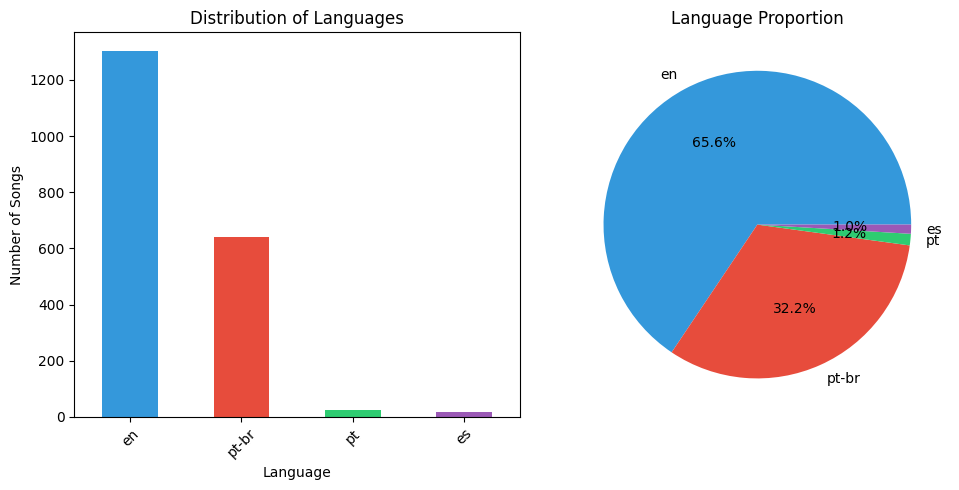

In [ ]:
# Explore language distribution
print("🌍 Language Distribution:")
lang_counts = df['music_lang'].value_counts()
print(lang_counts)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
lang_counts.plot(kind='bar', color=['#3498db', '#e74c3c', '#2ecc71', '#9b59b6'])
plt.title('Distribution of Languages')
plt.xlabel('Language')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(lang_counts.values, labels=lang_counts.index, autopct='%1.1f%%',
        colors=['#3498db', '#e74c3c', '#2ecc71', '#9b59b6'])
plt.title('Language Proportion')

plt.tight_layout()
plt.show()

### Genre Distribution Analysis

Genre labels serve as **pseudo ground truth** for evaluating clustering quality. We expect VAE to learn representations where similar genres cluster together.

🎸 Genre Distribution (Top 15):
main_genre
Pop                 350
Romantic            253
Gospel/Religious    206
Rock                157
Pop/Rock            124
Sertanejo            95
R&B                  91
Indie                82
Dance                81
Alternative Rock     76
Hip Hop              73
Rap                  46
MPB                  40
Electronic           37
Hard Rock            37
Name: count, dtype: int64


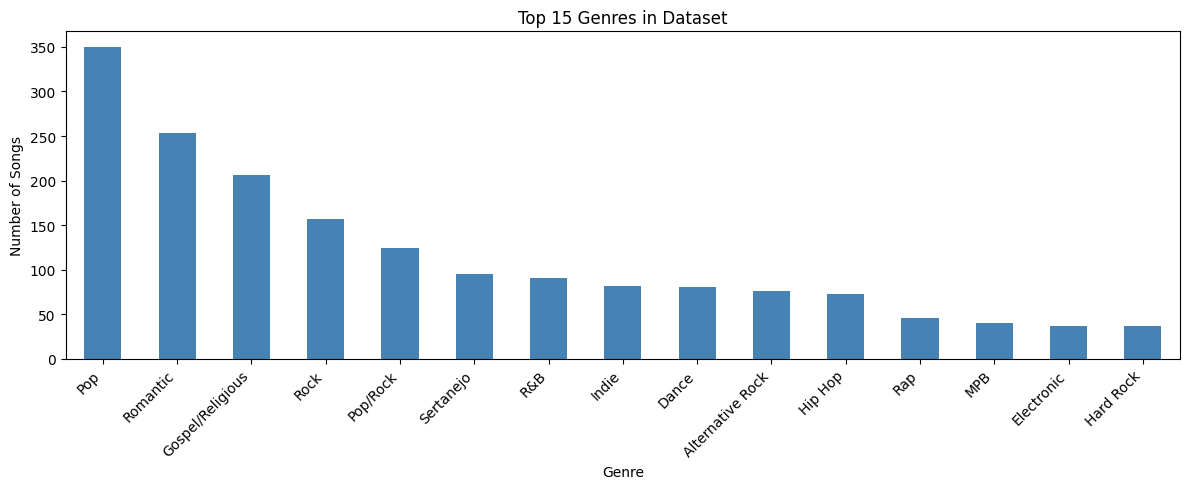

In [ ]:
# Explore genre distribution
print("🎸 Genre Distribution (Top 15):")
genre_counts = df['main_genre'].value_counts().head(15)
print(genre_counts)

plt.figure(figsize=(12, 5))
genre_counts.plot(kind='bar', color='steelblue')
plt.title('Top 15 Genres in Dataset')
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Inspect Melspectrogram Structure

**Melspectrograms** are time-frequency representations of audio signals. They capture:
- **Mel bands** (y-axis): Frequency information scaled to human perception
- **Time frames** (x-axis): Temporal evolution of the audio

Understanding the data structure is essential for proper feature extraction.

In [ ]:
# Deep inspection of melspectrogram structure
sample_mel = df['melspectrogram'].iloc[0]
print(f"Type of melspectrogram column: {type(sample_mel)}")
print(f"Length of outer array: {len(sample_mel)}")
print(f"Type of first element: {type(sample_mel[0])}")

# Convert properly to see the real shape
mel_array = np.array([np.array(row, dtype=np.float32) for row in sample_mel])
print(f"\n✅ Properly converted shape: {mel_array.shape}")
print(f"   - {mel_array.shape[0]} mel bands")
print(f"   - {mel_array.shape[1]} time frames")
print(f"Dtype: {mel_array.dtype}")

Type of melspectrogram column: <class 'numpy.ndarray'>
Length of outer array: 128
Type of first element: <class 'numpy.ndarray'>

✅ Properly converted shape: (128, 1292)
   - 128 mel bands
   - 1292 time frames
Dtype: float32


## 3. Data Preprocessing

### Feature Extraction from Melspectrograms

We extract **statistical features** from each mel band across time:
- **Mean**: Average energy in each frequency band
- **Std**: Variability/dynamics of the audio
- **Max/Min**: Peak and trough values

This reduces dimensionality while preserving discriminative information:
`(128 mel bands × T time frames) → (128 × 4 = 512 features)`

**Theory**: Statistical aggregation captures the spectral "fingerprint" of a song while being invariant to song length.

In [ ]:
# Extract and process melspectrogram features
def extract_features(mel_data):
    """
    Extract statistical features from melspectrogram.
    The melspectrogram is stored as a list of 128 arrays (mel bands x time frames).
    """
    # Convert nested structure to proper 2D numpy array
    mel_array = np.array([np.array(row, dtype=np.float32) for row in mel_data])

    # mel_array shape: (128 mel_bands, time_frames)
    # Compute statistics across time axis (axis=1)
    features = []

    features.extend(np.mean(mel_array, axis=1))  # Mean of each mel band
    features.extend(np.std(mel_array, axis=1))   # Std of each mel band
    features.extend(np.max(mel_array, axis=1))   # Max of each mel band
    features.extend(np.min(mel_array, axis=1))   # Min of each mel band

    return np.array(features, dtype=np.float32)

# Extract features for all songs
print("⏳ Extracting features from melspectrograms...")
features_list = []
valid_indices = []

for idx, mel in enumerate(df['melspectrogram']):
    try:
        feat = extract_features(mel)

        if not np.any(np.isnan(feat)) and not np.any(np.isinf(feat)):
            features_list.append(feat)
            valid_indices.append(idx)

    except Exception as e:
        print(f"Error at index {idx}: {e}")
        continue

    if (idx + 1) % 500 == 0:
        print(f"   Processed {idx + 1}/{len(df)} samples...")

# Create feature matrix
X = np.array(features_list)
print(f"\n✅ Feature matrix shape: {X.shape}")
print(f"✅ Valid samples: {len(valid_indices)} / {len(df)}")
print(f"✅ Features per sample: {X.shape[1]} (128 bands × 4 statistics)")

⏳ Extracting features from melspectrograms...
   Processed 500/1988 samples...
   Processed 1000/1988 samples...
   Processed 1500/1988 samples...

✅ Feature matrix shape: (1988, 512)
✅ Valid samples: 1988 / 1988
✅ Features per sample: 512 (128 bands × 4 statistics)


### Create Filtered Dataset and Encode Labels

We create a filtered dataframe containing only valid samples and encode categorical labels (genre, language) as integers for evaluation metrics.

In [ ]:
# Create filtered dataframe with valid indices
df_filtered = df.iloc[valid_indices].reset_index(drop=True)

# Encode labels for evaluation
label_encoder_genre = LabelEncoder()
label_encoder_lang = LabelEncoder()

genre_labels = label_encoder_genre.fit_transform(df_filtered['main_genre'])
lang_labels = label_encoder_lang.fit_transform(df_filtered['music_lang'])

print(f"🎸 Number of unique genres: {len(label_encoder_genre.classes_)}")
print(f"🌍 Number of unique languages: {len(label_encoder_lang.classes_)}")
print(f"\nGenres: {list(label_encoder_genre.classes_[:10])}...")

🎸 Number of unique genres: 27
🌍 Number of unique languages: 4

Genres: ['Alternative Rock', 'Black Music', 'Dance', 'Electronic', 'Gospel/Religious', 'Grunge', 'Hard Rock', 'Hip Hop', 'Indie', 'K-Pop/K-Rock']...


### Feature Normalization

**StandardScaler** normalizes features to zero mean and unit variance. This is critical because:
1. VAE training is sensitive to feature scales
2. Clustering algorithms like K-Means use Euclidean distance, which is scale-dependent
3. Prevents features with larger magnitudes from dominating

In [ ]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ Scaled features - Mean: {X_scaled.mean():.6f}, Std: {X_scaled.std():.6f}")
print(f"   Shape: {X_scaled.shape}")

✅ Scaled features - Mean: -0.000000, Std: 1.000000
   Shape: (1988, 512)


## 4. Variational Autoencoder (VAE) Implementation

### VAE Theory

A **Variational Autoencoder** learns a probabilistic latent representation:

1. **Encoder** `q(z|x)`: Maps input x to latent distribution parameters (μ, σ)
2. **Reparameterization**: Samples z = μ + σ × ε, where ε ~ N(0,1)
3. **Decoder** `p(x|z)`: Reconstructs input from latent code

**Loss Function:**
$$\mathcal{L} = \underbrace{||x - \hat{x}||^2}_{\text{Reconstruction}} + \beta \cdot \underbrace{D_{KL}(q(z|x) || p(z))}_{\text{KL Divergence}}$$

**Why VAE for clustering?**
- Learns smooth, continuous latent space
- KL term encourages disentangled representations
- Latent features capture semantic similarity

In [ ]:
class VAE(nn.Module):
    """
    Variational Autoencoder for music feature extraction.

    Architecture:
    - Encoder: Input -> Hidden layers -> Mean & Log-variance
    - Latent space: Reparameterization trick
    - Decoder: Latent -> Hidden layers -> Reconstruction
    """

    def __init__(self, input_dim, hidden_dim=256, latent_dim=32):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        # Latent space parameters
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim),
        )

    def encode(self, x):
        """Encode input to latent distribution parameters."""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick: z = mu + std * epsilon
        This allows backpropagation through stochastic sampling.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """Decode latent representation to reconstruction."""
        return self.decoder(z)

    def forward(self, x):
        """Full forward pass."""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z

print("✅ VAE class defined!")

✅ VAE class defined!


### VAE Loss Function

The loss combines:
1. **Reconstruction Loss (MSE)**: Measures how well the decoder reconstructs the input
2. **KL Divergence**: Regularizes latent space to be close to N(0,1)

The **β parameter** controls the trade-off:
- β=1: Standard VAE
- β>1: More disentangled but potentially worse reconstruction

In [ ]:
def vae_loss(x_recon, x, mu, logvar, beta=1.0):
    """
    VAE Loss = Reconstruction Loss + β × KL Divergence

    KL Divergence formula: -0.5 * sum(1 + log(σ²) - μ² - σ²)
    """
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')

    # KL Divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_loss, recon_loss, kl_loss

print("✅ Loss function defined!")

✅ Loss function defined!


### Hyperparameter Configuration

Key hyperparameters:
- **LATENT_DIM=32**: Compressed representation size (512 → 32 = 16x compression)
- **HIDDEN_DIM=256**: Encoder/decoder capacity
- **EPOCHS=100**: Training iterations
- **BETA=1.0**: KL weight (standard VAE)

In [ ]:
# Hyperparameters
INPUT_DIM = X_scaled.shape[1]
HIDDEN_DIM = 256
LATENT_DIM = 32
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
EPOCHS = 100
BETA = 1.0

print(f"📊 Model Configuration:")
print(f"   Input Dimension: {INPUT_DIM}")
print(f"   Hidden Dimension: {HIDDEN_DIM}")
print(f"   Latent Dimension: {LATENT_DIM}")
print(f"   Compression Ratio: {INPUT_DIM/LATENT_DIM:.1f}x")

📊 Model Configuration:
   Input Dimension: 512
   Hidden Dimension: 256
   Latent Dimension: 32
   Compression Ratio: 16.0x


### Initialize Model and Optimizer

- **Adam optimizer**: Adaptive learning rate, works well for VAEs
- **ReduceLROnPlateau**: Reduces learning rate when loss plateaus

In [ ]:
# Prepare data loaders
X_tensor = torch.FloatTensor(X_scaled)
dataset = TensorDataset(X_tensor, X_tensor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize model, optimizer
vae = VAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).to(device)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

print(f"🏗️ Model Architecture:")
print(vae)
print(f"\n📈 Total Parameters: {sum(p.numel() for p in vae.parameters()):,}")

🏗️ Model Architecture:
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
  )
  (fc_mu): Linear(in_features=128, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()


### Training Loop

**Expected behavior:**
- Reconstruction loss should decrease steadily
- KL loss may increase initially as latent space is regularized
- Total loss should converge after ~50-100 epochs

In [ ]:
# Training loop
print("🚀 Starting VAE Training...\n")

history = {'total_loss': [], 'recon_loss': [], 'kl_loss': []}

vae.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0

    for batch_x, _ in dataloader:
        batch_x = batch_x.to(device)

        # Forward pass
        x_recon, mu, logvar, z = vae(batch_x)

        # Compute loss
        loss, recon_loss, kl_loss = vae_loss(x_recon, batch_x, mu, logvar, BETA)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()

    # Average losses
    avg_loss = epoch_loss / len(dataloader.dataset)
    avg_recon = epoch_recon / len(dataloader.dataset)
    avg_kl = epoch_kl / len(dataloader.dataset)

    history['total_loss'].append(avg_loss)
    history['recon_loss'].append(avg_recon)
    history['kl_loss'].append(avg_kl)

    scheduler.step(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] | Total: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f}")

print("\n✅ Training Complete!")

🚀 Starting VAE Training...

Epoch [10/100] | Total: 307.8146 | Recon: 292.3980 | KL: 15.4166
Epoch [20/100] | Total: 277.6211 | Recon: 260.6842 | KL: 16.9370
Epoch [30/100] | Total: 259.3021 | Recon: 242.4947 | KL: 16.8074
Epoch [40/100] | Total: 244.8772 | Recon: 227.5606 | KL: 17.3167
Epoch [50/100] | Total: 235.9547 | Recon: 218.8608 | KL: 17.0939
Epoch [60/100] | Total: 234.1468 | Recon: 217.6441 | KL: 16.5027
Epoch [70/100] | Total: 232.2701 | Recon: 216.0407 | KL: 16.2293
Epoch [80/100] | Total: 225.5833 | Recon: 209.6152 | KL: 15.9681
Epoch [90/100] | Total: 214.9916 | Recon: 199.0175 | KL: 15.9741
Epoch [100/100] | Total: 222.9930 | Recon: 207.3337 | KL: 15.6593

✅ Training Complete!


### Training Curves Visualization

Analyzing training curves helps diagnose:
- **Overfitting**: If loss starts increasing
- **KL collapse**: If KL loss approaches zero (latent space not being used)
- **Convergence**: Stable loss values indicate training completion

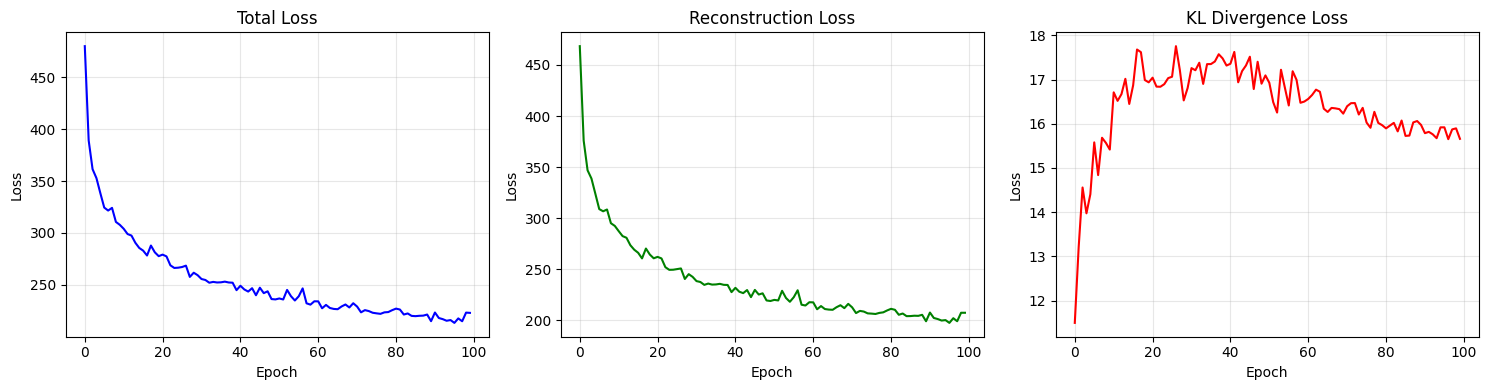

In [ ]:
# Plot training curves
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(history['total_loss'], color='blue')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history['recon_loss'], color='green')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history['kl_loss'], color='red')
plt.title('KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Extract Latent Features

We extract the **mean (μ)** of the latent distribution as our feature representation:
- More stable than sampled z values
- Represents the "center" of where the encoder maps each input
- These 32-dimensional vectors will be used for clustering

In [ ]:
# Extract latent representations
vae.eval()
with torch.no_grad():
    X_tensor = torch.FloatTensor(X_scaled).to(device)
    _, mu, _, z = vae(X_tensor)

    # Use mean (mu) as latent representation
    latent_features = mu.cpu().numpy()

print(f"✅ Latent features shape: {latent_features.shape}")
print(f"   Reduced from {X_scaled.shape[1]} to {latent_features.shape[1]} dimensions")
print(f"   Compression: {X_scaled.shape[1]/latent_features.shape[1]:.1f}x")

✅ Latent features shape: (1988, 32)
   Reduced from 512 to 32 dimensions
   Compression: 16.0x


## 6. Clustering with K-Means

### Finding Optimal K

We use multiple methods to determine the optimal number of clusters:
1. **Elbow Method**: Look for "elbow" in inertia curve
2. **Silhouette Score**: Higher is better (measures cluster cohesion vs separation)
3. **Calinski-Harabasz Index**: Higher is better (ratio of between/within cluster variance)

**Expected**: Optimal K should be around 5-15 for this dataset based on genre diversity.

In [ ]:
# Determine optimal number of clusters
K_range = range(2, 16)
inertias = []
silhouette_scores_list = []
ch_scores = []

print("🔍 Finding optimal number of clusters...\n")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    clusters = kmeans.fit_predict(latent_features)

    inertias.append(kmeans.inertia_)
    silhouette_scores_list.append(silhouette_score(latent_features, clusters))
    ch_scores.append(calinski_harabasz_score(latent_features, clusters))

    print(f"K={k:2d} | Silhouette: {silhouette_scores_list[-1]:.4f} | CH Index: {ch_scores[-1]:.2f}")

# Find optimal K
optimal_k_silhouette = K_range[np.argmax(silhouette_scores_list)]
optimal_k_ch = K_range[np.argmax(ch_scores)]

print(f"\n🎯 Optimal K (Silhouette): {optimal_k_silhouette}")
print(f"🎯 Optimal K (Calinski-Harabasz): {optimal_k_ch}")

🔍 Finding optimal number of clusters...

K= 2 | Silhouette: 0.2573 | CH Index: 306.28
K= 3 | Silhouette: 0.2611 | CH Index: 258.72
K= 4 | Silhouette: 0.2553 | CH Index: 240.83
K= 5 | Silhouette: 0.2472 | CH Index: 236.55
K= 6 | Silhouette: 0.2633 | CH Index: 233.85
K= 7 | Silhouette: 0.2430 | CH Index: 227.03
K= 8 | Silhouette: 0.1702 | CH Index: 219.39
K= 9 | Silhouette: 0.1706 | CH Index: 215.93
K=10 | Silhouette: 0.1751 | CH Index: 209.16
K=11 | Silhouette: 0.1813 | CH Index: 206.81
K=12 | Silhouette: 0.1814 | CH Index: 201.35
K=13 | Silhouette: 0.1808 | CH Index: 193.22
K=14 | Silhouette: 0.1861 | CH Index: 184.74
K=15 | Silhouette: 0.1836 | CH Index: 180.63

🎯 Optimal K (Silhouette): 6
🎯 Optimal K (Calinski-Harabasz): 2


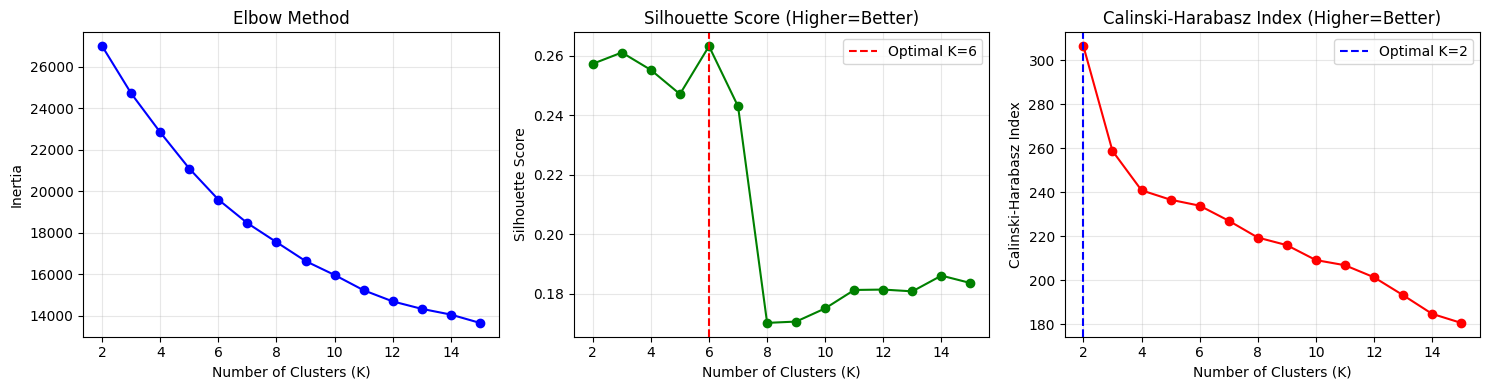

In [ ]:
# Plot cluster selection metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores_list, 'go-')
axes[1].axvline(x=optimal_k_silhouette, color='r', linestyle='--', label=f'Optimal K={optimal_k_silhouette}')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score (Higher=Better)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(K_range, ch_scores, 'ro-')
axes[2].axvline(x=optimal_k_ch, color='b', linestyle='--', label=f'Optimal K={optimal_k_ch}')
axes[2].set_xlabel('Number of Clusters (K)')
axes[2].set_ylabel('Calinski-Harabasz Index')
axes[2].set_title('Calinski-Harabasz Index (Higher=Better)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cluster_selection.png', dpi=150, bbox_inches='tight')
plt.show()

### Final K-Means Clustering

Apply K-Means with optimal K to create cluster assignments.

In [ ]:
# Final K-Means clustering with optimal K
OPTIMAL_K = optimal_k_silhouette

kmeans_vae = KMeans(n_clusters=OPTIMAL_K, random_state=SEED, n_init=10)
vae_clusters = kmeans_vae.fit_predict(latent_features)

print(f"✅ Final clustering with K={OPTIMAL_K}")
print(f"\n📊 Cluster Distribution:")
for i, count in enumerate(np.bincount(vae_clusters)):
    print(f"   Cluster {i}: {count} songs ({count/len(vae_clusters)*100:.1f}%)")

✅ Final clustering with K=6

📊 Cluster Distribution:
   Cluster 0: 537 songs (27.0%)
   Cluster 1: 1076 songs (54.1%)
   Cluster 2: 1 songs (0.1%)
   Cluster 3: 8 songs (0.4%)
   Cluster 4: 48 songs (2.4%)
   Cluster 5: 318 songs (16.0%)


## 7. Baseline: PCA + K-Means

**PCA (Principal Component Analysis)** is a linear dimensionality reduction technique:
- Projects data onto orthogonal principal components
- Maximizes variance in reduced space

**Why compare with PCA?**
- PCA is a strong baseline for dimensionality reduction
- VAE should capture non-linear relationships that PCA cannot
- If VAE performs worse than PCA, the data may have linear structure

In [ ]:
# PCA baseline with same dimensionality as VAE latent space
pca = PCA(n_components=LATENT_DIM, random_state=SEED)
pca_features = pca.fit_transform(X_scaled)

print(f"✅ PCA features shape: {pca_features.shape}")
print(f"📊 Explained variance ratio: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# K-Means on PCA features
kmeans_pca = KMeans(n_clusters=OPTIMAL_K, random_state=SEED, n_init=10)
pca_clusters = kmeans_pca.fit_predict(pca_features)

print(f"\n✅ PCA + K-Means clustering complete")

✅ PCA features shape: (1988, 32)
📊 Explained variance ratio: 81.70%

✅ PCA + K-Means clustering complete


## 8. Comparison: VAE vs PCA Baseline

### Evaluation Metrics

| Metric | Description | Better |
|--------|-------------|--------|
| **Silhouette Score** | Measures cohesion vs separation (-1 to 1) | Higher |
| **Calinski-Harabasz** | Ratio of between/within cluster variance | Higher |

**Expected outcome**: VAE should perform comparably or better due to non-linear feature learning.

In [ ]:
# Calculate metrics for both methods
metrics_easy = {
    'Method': ['VAE + K-Means', 'PCA + K-Means'],
    'Silhouette Score': [
        silhouette_score(latent_features, vae_clusters),
        silhouette_score(pca_features, pca_clusters)
    ],
    'Calinski-Harabasz Index': [
        calinski_harabasz_score(latent_features, vae_clusters),
        calinski_harabasz_score(pca_features, pca_clusters)
    ]
}

metrics_easy_df = pd.DataFrame(metrics_easy)
print("\n" + "="*60)
print("📊 EASY TASK: CLUSTERING METRICS COMPARISON")
print("="*60)
print(metrics_easy_df.to_string(index=False))
print("="*60)


📊 EASY TASK: CLUSTERING METRICS COMPARISON
       Method  Silhouette Score  Calinski-Harabasz Index
VAE + K-Means          0.263276               233.854965
PCA + K-Means          0.322424               321.772797


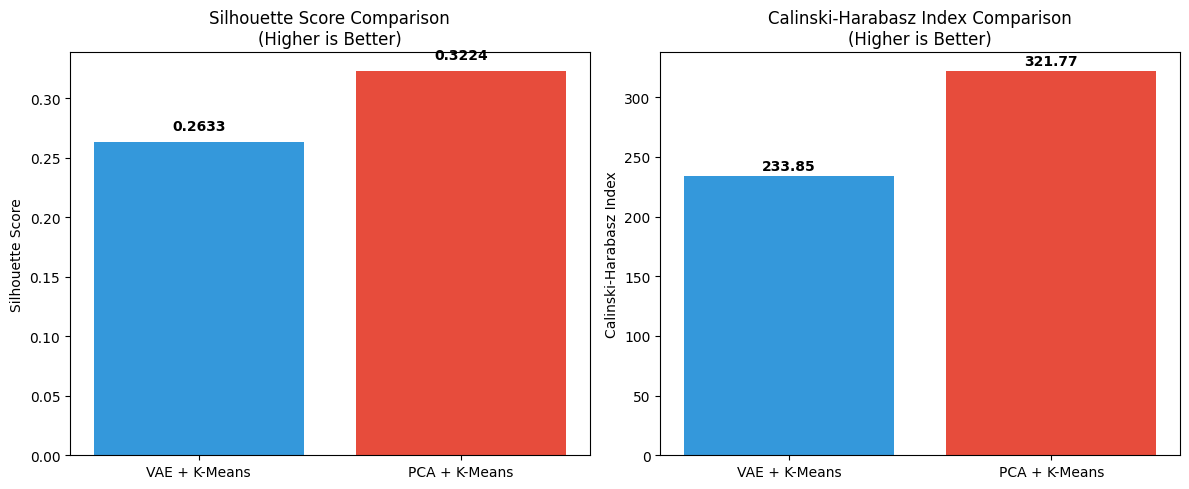

In [ ]:
# Visualize metric comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = ['#3498db', '#e74c3c']

axes[0].bar(metrics_easy['Method'], metrics_easy['Silhouette Score'], color=colors)
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score Comparison\n(Higher is Better)')
for i, v in enumerate(metrics_easy['Silhouette Score']):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

axes[1].bar(metrics_easy['Method'], metrics_easy['Calinski-Harabasz Index'], color=colors)
axes[1].set_ylabel('Calinski-Harabasz Index')
axes[1].set_title('Calinski-Harabasz Index Comparison\n(Higher is Better)')
for i, v in enumerate(metrics_easy['Calinski-Harabasz Index']):
    axes[1].text(i, v + 5, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('metrics_comparison_easy.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Visualization: t-SNE

**t-SNE (t-Distributed Stochastic Neighbor Embedding)**:
- Non-linear dimensionality reduction for visualization
- Preserves local neighborhood structure
- Good for visualizing cluster separation

**Perplexity parameter**: Controls the balance between local and global structure (30 is typical)

In [ ]:
# t-SNE visualization
print("⏳ Computing t-SNE embeddings...")

tsne_vae = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000).fit_transform(latent_features)
tsne_pca = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000).fit_transform(pca_features)

print("✅ t-SNE complete!")

⏳ Computing t-SNE embeddings...
✅ t-SNE complete!


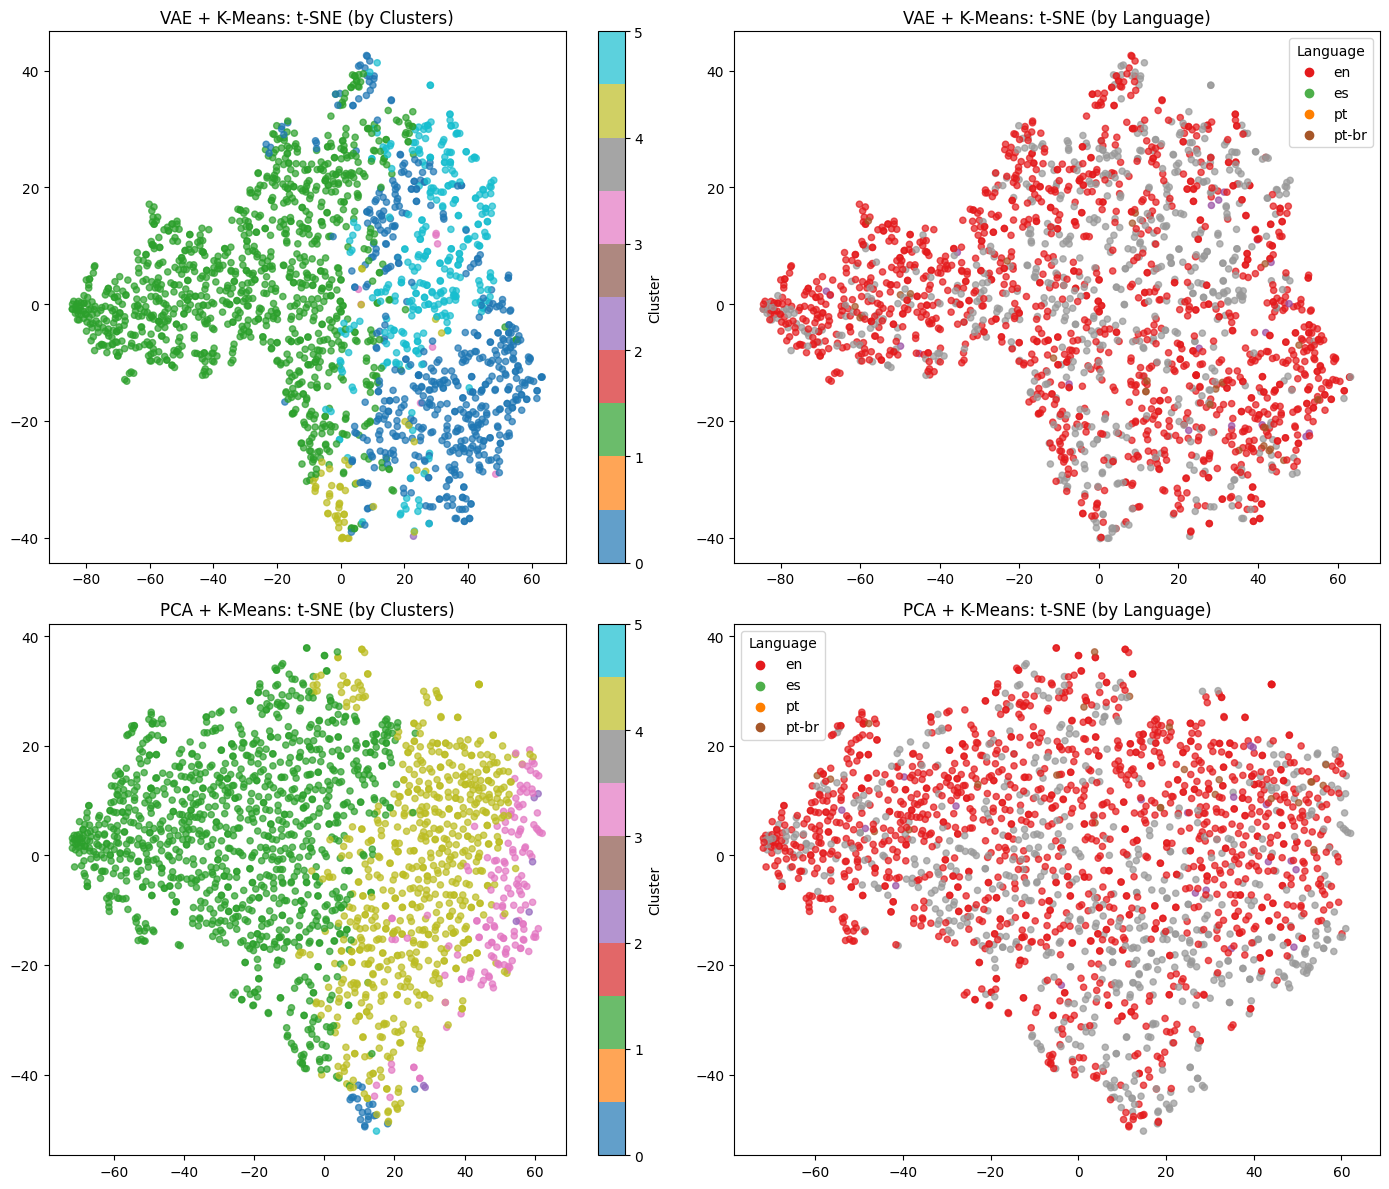

In [ ]:
# Plot t-SNE visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# VAE t-SNE colored by clusters
scatter1 = axes[0, 0].scatter(tsne_vae[:, 0], tsne_vae[:, 1], c=vae_clusters, cmap='tab10', alpha=0.7, s=20)
axes[0, 0].set_title('VAE + K-Means: t-SNE (by Clusters)')
plt.colorbar(scatter1, ax=axes[0, 0], label='Cluster')

# VAE t-SNE colored by language
scatter2 = axes[0, 1].scatter(tsne_vae[:, 0], tsne_vae[:, 1], c=lang_labels, cmap='Set1', alpha=0.7, s=20)
axes[0, 1].set_title('VAE + K-Means: t-SNE (by Language)')
handles = [plt.scatter([], [], c=plt.cm.Set1(i/len(label_encoder_lang.classes_)),
           label=label_encoder_lang.classes_[i]) for i in range(len(label_encoder_lang.classes_))]
axes[0, 1].legend(handles=handles, title='Language')

# PCA t-SNE colored by clusters
scatter3 = axes[1, 0].scatter(tsne_pca[:, 0], tsne_pca[:, 1], c=pca_clusters, cmap='tab10', alpha=0.7, s=20)
axes[1, 0].set_title('PCA + K-Means: t-SNE (by Clusters)')
plt.colorbar(scatter3, ax=axes[1, 0], label='Cluster')

# PCA t-SNE colored by language
scatter4 = axes[1, 1].scatter(tsne_pca[:, 0], tsne_pca[:, 1], c=lang_labels, cmap='Set1', alpha=0.7, s=20)
axes[1, 1].set_title('PCA + K-Means: t-SNE (by Language)')
axes[1, 1].legend(handles=handles, title='Language')

plt.tight_layout()
plt.savefig('tsne_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Visualization: UMAP

**UMAP (Uniform Manifold Approximation and Projection)**:
- Often preserves global structure better than t-SNE
- Faster computation
- Better at preserving distances between clusters

In [ ]:
# UMAP visualization
print("⏳ Computing UMAP embeddings...")

umap_vae = umap.UMAP(n_components=2, random_state=SEED, n_neighbors=15, min_dist=0.1).fit_transform(latent_features)
umap_pca = umap.UMAP(n_components=2, random_state=SEED, n_neighbors=15, min_dist=0.1).fit_transform(pca_features)

print("✅ UMAP complete!")

⏳ Computing UMAP embeddings...
✅ UMAP complete!


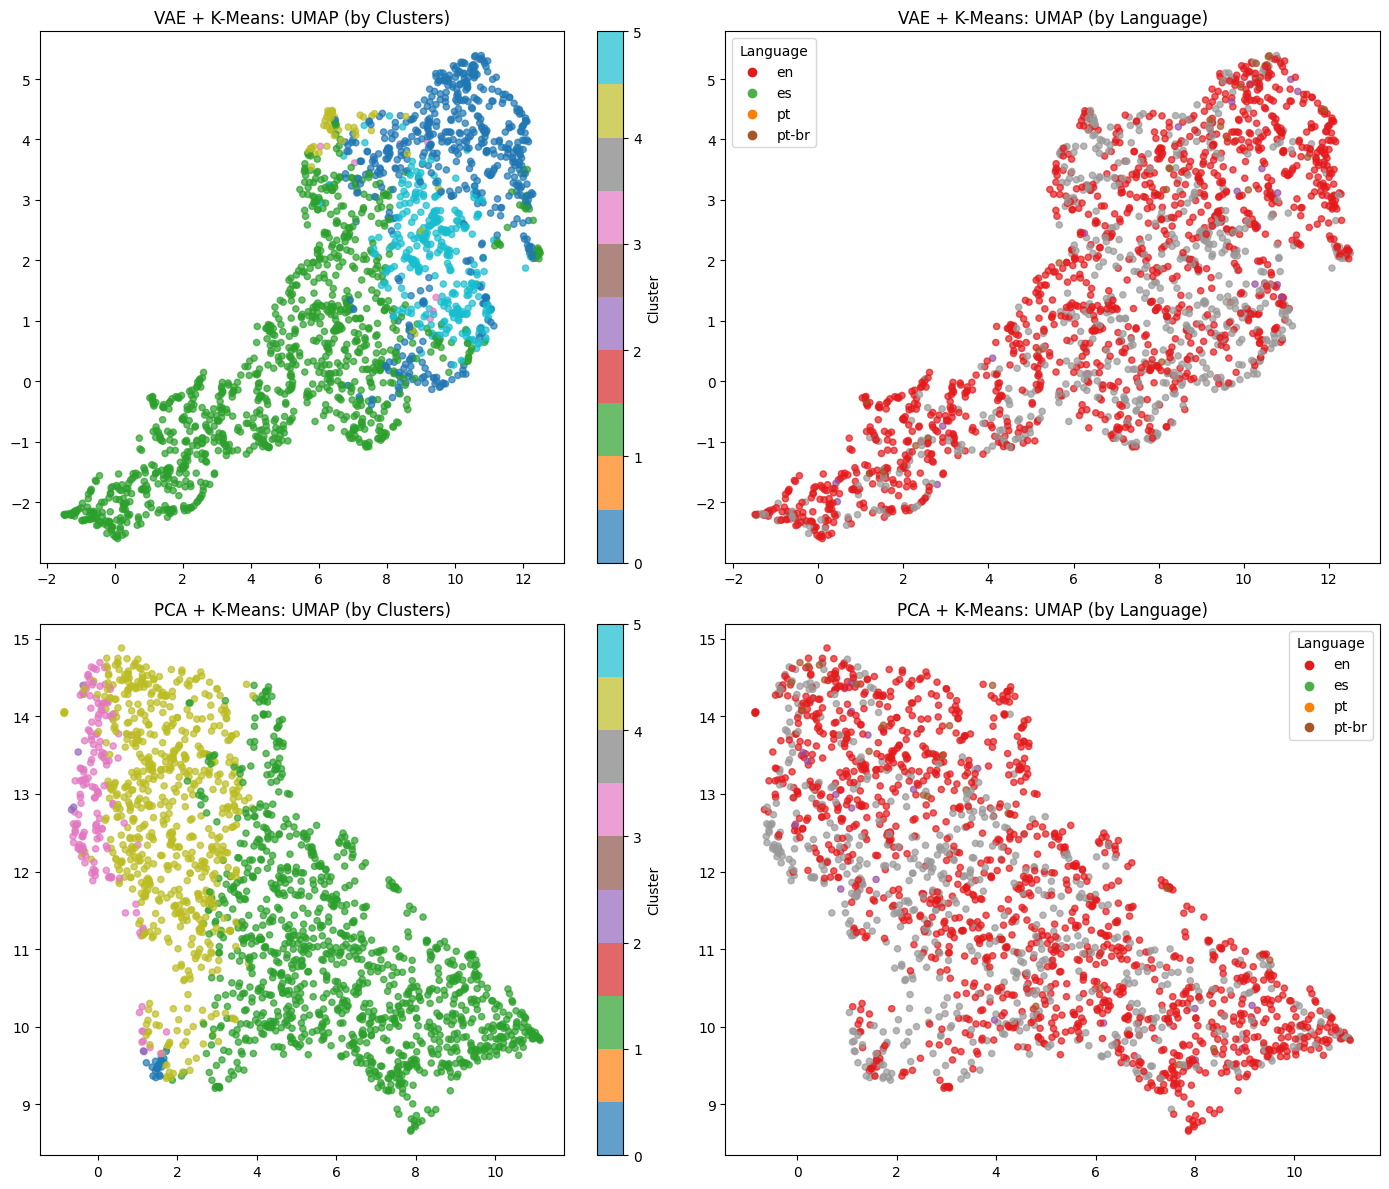

In [ ]:
# Plot UMAP visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

scatter1 = axes[0, 0].scatter(umap_vae[:, 0], umap_vae[:, 1], c=vae_clusters, cmap='tab10', alpha=0.7, s=20)
axes[0, 0].set_title('VAE + K-Means: UMAP (by Clusters)')
plt.colorbar(scatter1, ax=axes[0, 0], label='Cluster')

scatter2 = axes[0, 1].scatter(umap_vae[:, 0], umap_vae[:, 1], c=lang_labels, cmap='Set1', alpha=0.7, s=20)
axes[0, 1].set_title('VAE + K-Means: UMAP (by Language)')
axes[0, 1].legend(handles=handles, title='Language')

scatter3 = axes[1, 0].scatter(umap_pca[:, 0], umap_pca[:, 1], c=pca_clusters, cmap='tab10', alpha=0.7, s=20)
axes[1, 0].set_title('PCA + K-Means: UMAP (by Clusters)')
plt.colorbar(scatter3, ax=axes[1, 0], label='Cluster')

scatter4 = axes[1, 1].scatter(umap_pca[:, 0], umap_pca[:, 1], c=lang_labels, cmap='Set1', alpha=0.7, s=20)
axes[1, 1].set_title('PCA + K-Means: UMAP (by Language)')
axes[1, 1].legend(handles=handles, title='Language')

plt.tight_layout()
plt.savefig('umap_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Easy Task Summary

In [ ]:
# Easy Task Summary
print("\n" + "="*70)
print("                    📊 EASY TASK SUMMARY")
print("="*70)
print(f"\n✅ Dataset: {len(df_filtered)} songs, {df_filtered['main_genre'].nunique()} genres")
print(f"✅ Languages: {', '.join(df_filtered['music_lang'].unique())}")
print(f"✅ VAE: {INPUT_DIM} → {LATENT_DIM} dimensions")
print(f"✅ Optimal Clusters: K={OPTIMAL_K}")
print(f"\n📈 Results:")
print(metrics_easy_df.to_string(index=False))
print("="*70)


                    📊 EASY TASK SUMMARY

✅ Dataset: 1988 songs, 27 genres
✅ Languages: pt-br, en, es, pt
✅ VAE: 512 → 32 dimensions
✅ Optimal Clusters: K=6

📈 Results:
       Method  Silhouette Score  Calinski-Harabasz Index
VAE + K-Means          0.263276               233.854965
PCA + K-Means          0.322424               321.772797


---
# PART 2: MEDIUM TASK
---

## Medium Task Objectives:
1. **Convolutional VAE** for spectrogram features
2. **Hybrid features**: Audio + Lyrics embeddings
3. **Multiple clustering algorithms**: K-Means, Agglomerative, DBSCAN
4. **Extended metrics**: Davies-Bouldin Index, Adjusted Rand Index

## 12. Convolutional VAE Implementation

### Why Convolutional VAE?

**Limitations of basic VAE**:
- Treats input as flat vector, loses spatial structure
- Statistical features (mean, std) discard temporal patterns

**Advantages of Conv-VAE**:
- Preserves 2D structure of spectrograms (frequency × time)
- Learns hierarchical features (edges → textures → patterns)
- Weight sharing reduces parameters

**Architecture**:
```
Input (128×T) → Conv2D → Conv2D → Flatten → μ, σ → Latent (64)
                                              ↓
Output (128×T) ← ConvT2D ← ConvT2D ← Reshape ←
```

In [ ]:
class ConvVAE(nn.Module):
    """
    Convolutional VAE for 2D spectrogram features.

    Uses Conv2D layers to preserve spatial structure of spectrograms.
    """

    def __init__(self, input_channels=1, latent_dim=64, input_height=128, input_width=None):
        super(ConvVAE, self).__init__()

        self.latent_dim = latent_dim
        self.input_height = input_height
        self.input_width = input_width

        # Encoder: Conv layers
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Calculate flattened size after conv layers
        # After 3 stride-2 convs: H/8 x W/8
        self.h_out = input_height // 8
        self.w_out = input_width // 8 if input_width else 1
        self.flatten_size = 128 * self.h_out * self.w_out

        # Latent space
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)

        # Decoder: Transposed Conv layers
        self.fc_decode = nn.Linear(latent_dim, self.flatten_size)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def encode(self, x):
        h = self.encoder_conv(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(h.size(0), 128, self.h_out, self.w_out)
        return self.decoder_conv(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z

print("✅ ConvVAE class defined!")

✅ ConvVAE class defined!


### Prepare 2D Spectrogram Data for Conv-VAE

We need to convert the nested melspectrogram data to proper 2D tensors:
- Shape: `(N, 1, 128, T)` where 1 is the channel dimension
- Pad/truncate to consistent width T

In [ ]:
# Prepare 2D spectrogram data for Conv-VAE
print("⏳ Preparing 2D spectrograms for Conv-VAE...")

def prepare_2d_spectrogram(mel_data, target_width=128):
    """Convert melspectrogram to 2D array with consistent width."""
    mel_array = np.array([np.array(row, dtype=np.float32) for row in mel_data])

    # Pad or truncate to target width
    if mel_array.shape[1] < target_width:
        pad_width = target_width - mel_array.shape[1]
        mel_array = np.pad(mel_array, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_array = mel_array[:, :target_width]

    return mel_array

# Find common width
widths = [np.array(mel).shape[1] if len(np.array(mel).shape) > 1 else len(mel)
          for mel in df_filtered['melspectrogram'].iloc[:10]]
print(f"Sample widths: {widths}")

# Use fixed target width (power of 2 for conv layers)
TARGET_WIDTH = 128

# Prepare all spectrograms
spectrograms_2d = []
for idx, mel in enumerate(df_filtered['melspectrogram']):
    try:
        spec = prepare_2d_spectrogram(mel, TARGET_WIDTH)
        spectrograms_2d.append(spec)
    except Exception as e:
        print(f"Error at {idx}: {e}")
        # Use zeros as placeholder
        spectrograms_2d.append(np.zeros((128, TARGET_WIDTH), dtype=np.float32))

# Convert to tensor: (N, 1, H, W)
X_2d = np.array(spectrograms_2d)[:, np.newaxis, :, :]
print(f"\n✅ 2D Spectrogram tensor shape: {X_2d.shape}")

⏳ Preparing 2D spectrograms for Conv-VAE...
Sample widths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128]

✅ 2D Spectrogram tensor shape: (1988, 1, 128, 128)


### Normalize 2D Data

In [ ]:
# Normalize 2D spectrograms
X_2d_mean = X_2d.mean()
X_2d_std = X_2d.std()
X_2d_normalized = (X_2d - X_2d_mean) / (X_2d_std + 1e-8)

print(f"✅ Normalized - Mean: {X_2d_normalized.mean():.6f}, Std: {X_2d_normalized.std():.6f}")

✅ Normalized - Mean: 0.000000, Std: 0.999998


### Train Convolutional VAE

**Expected behavior**:
- Conv-VAE should learn spatial patterns in spectrograms
- May require more epochs to converge due to increased complexity

In [ ]:
# Conv-VAE hyperparameters
CONV_LATENT_DIM = 64
CONV_EPOCHS = 50  # Fewer epochs due to larger model
CONV_BATCH_SIZE = 32

# Prepare data loader
X_2d_tensor = torch.FloatTensor(X_2d_normalized)
conv_dataset = TensorDataset(X_2d_tensor, X_2d_tensor)
conv_dataloader = DataLoader(conv_dataset, batch_size=CONV_BATCH_SIZE, shuffle=True)

# Initialize Conv-VAE
conv_vae = ConvVAE(
    input_channels=1,
    latent_dim=CONV_LATENT_DIM,
    input_height=128,
    input_width=TARGET_WIDTH
).to(device)

conv_optimizer = optim.Adam(conv_vae.parameters(), lr=1e-3)

print(f"🏗️ Conv-VAE Parameters: {sum(p.numel() for p in conv_vae.parameters()):,}")

🏗️ Conv-VAE Parameters: 6,510,209


In [ ]:
# Train Conv-VAE
print("🚀 Training Conv-VAE...\n")

conv_history = {'total_loss': [], 'recon_loss': [], 'kl_loss': []}

conv_vae.train()
for epoch in range(CONV_EPOCHS):
    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0

    for batch_x, _ in conv_dataloader:
        batch_x = batch_x.to(device)

        x_recon, mu, logvar, z = conv_vae(batch_x)

        # Resize reconstruction to match input if needed
        if x_recon.shape != batch_x.shape:
            x_recon = nn.functional.interpolate(x_recon, size=batch_x.shape[2:], mode='bilinear')

        loss, recon_loss, kl_loss = vae_loss(x_recon, batch_x, mu, logvar, beta=0.5)

        conv_optimizer.zero_grad()
        loss.backward()
        conv_optimizer.step()

        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()

    avg_loss = epoch_loss / len(conv_dataloader.dataset)
    conv_history['total_loss'].append(avg_loss)
    conv_history['recon_loss'].append(epoch_recon / len(conv_dataloader.dataset))
    conv_history['kl_loss'].append(epoch_kl / len(conv_dataloader.dataset))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{CONV_EPOCHS}] | Loss: {avg_loss:.4f}")

print("\n✅ Conv-VAE Training Complete!")

🚀 Training Conv-VAE...

Epoch [10/50] | Loss: 886510.6526
Epoch [20/50] | Loss: 9610.7727
Epoch [30/50] | Loss: 8503.7935
Epoch [40/50] | Loss: 7430.5566
Epoch [50/50] | Loss: 6585.9145

✅ Conv-VAE Training Complete!


### Extract Conv-VAE Latent Features

In [ ]:
# Extract Conv-VAE latent features
conv_vae.eval()
with torch.no_grad():
    X_2d_tensor = torch.FloatTensor(X_2d_normalized).to(device)
    _, conv_mu, _, _ = conv_vae(X_2d_tensor)
    conv_latent_features = conv_mu.cpu().numpy()

print(f"✅ Conv-VAE latent features shape: {conv_latent_features.shape}")

✅ Conv-VAE latent features shape: (1988, 64)


## 13. Lyrics Embeddings

### Why Add Lyrics?

**Multimodal learning** combines different data types:
- **Audio features**: Capture musical/acoustic characteristics
- **Lyrics embeddings**: Capture semantic/thematic content

Songs with similar themes (love, party, sadness) may cluster together even if acoustically different.

**Using Sentence-BERT**:
- Pre-trained multilingual transformer model
- Generates 384-dimensional embeddings
- Handles multiple languages (English, Portuguese, Spanish)

In [ ]:
# Load Sentence-BERT for lyrics embeddings
from sentence_transformers import SentenceTransformer

print("⏳ Loading multilingual sentence transformer...")
sentence_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print("✅ Model loaded!")

⏳ Loading multilingual sentence transformer...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Model loaded!


In [ ]:
# Generate lyrics embeddings
print("⏳ Generating lyrics embeddings...")

# Get lyrics, handle missing values
lyrics_list = df_filtered['music_lyrics'].fillna('').tolist()

# Truncate very long lyrics (transformer has max length)
MAX_CHARS = 5000
lyrics_truncated = [lyric[:MAX_CHARS] if len(lyric) > MAX_CHARS else lyric for lyric in lyrics_list]

# Generate embeddings in batches
lyrics_embeddings = sentence_model.encode(
    lyrics_truncated,
    show_progress_bar=True,
    batch_size=32
)

print(f"\n✅ Lyrics embeddings shape: {lyrics_embeddings.shape}")

⏳ Generating lyrics embeddings...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]


✅ Lyrics embeddings shape: (1988, 384)


### Combine Audio and Lyrics Features (Hybrid Representation)

**Feature fusion strategies**:
1. **Early fusion (concatenation)**: Combine raw features before learning
2. **Late fusion**: Combine predictions from separate models

We use **early fusion** by concatenating:
- VAE audio features (32 dim)
- Lyrics embeddings (384 dim)

Then normalize the combined features.

In [ ]:
# Normalize lyrics embeddings
lyrics_scaler = StandardScaler()
lyrics_scaled = lyrics_scaler.fit_transform(lyrics_embeddings)

# Combine audio (VAE) and lyrics features
print("🔗 Creating hybrid features (audio + lyrics)...")

# Option 1: VAE audio + lyrics
hybrid_features_vae = np.concatenate([latent_features, lyrics_scaled], axis=1)
print(f"   VAE + Lyrics: {hybrid_features_vae.shape}")

# Option 2: Conv-VAE audio + lyrics
hybrid_features_conv = np.concatenate([conv_latent_features, lyrics_scaled], axis=1)
print(f"   Conv-VAE + Lyrics: {hybrid_features_conv.shape}")

# Normalize hybrid features
hybrid_scaler = StandardScaler()
hybrid_features_vae_scaled = hybrid_scaler.fit_transform(hybrid_features_vae)
hybrid_features_conv_scaled = StandardScaler().fit_transform(hybrid_features_conv)

print("\n✅ Hybrid features ready!")

🔗 Creating hybrid features (audio + lyrics)...
   VAE + Lyrics: (1988, 416)
   Conv-VAE + Lyrics: (1988, 448)

✅ Hybrid features ready!


## 14. Multiple Clustering Algorithms

### Algorithm Comparison

| Algorithm | Characteristics | When to Use |
|-----------|----------------|-------------|
| **K-Means** | Spherical clusters, fast | Balanced, well-separated clusters |
| **Agglomerative** | Hierarchical, no K needed | Nested/hierarchical structure |
| **DBSCAN** | Density-based, finds outliers | Irregular shapes, noise |

**Expected results**:
- K-Means: Good for genre-based clusters
- Agglomerative: May reveal genre hierarchies
- DBSCAN: May identify outlier songs

In [ ]:
def evaluate_clustering(features, clusters, true_labels, method_name):
    """
    Evaluate clustering with multiple metrics.

    Returns dict with:
    - Silhouette Score: Cluster cohesion vs separation
    - Davies-Bouldin Index: Cluster similarity (lower=better)
    - Calinski-Harabasz: Between/within variance ratio
    - Adjusted Rand Index: Agreement with true labels
    """
    # Filter out noise points for DBSCAN (label=-1)
    valid_mask = clusters >= 0

    if valid_mask.sum() < 2 or len(np.unique(clusters[valid_mask])) < 2:
        return {
            'Method': method_name,
            'Silhouette': np.nan,
            'Davies-Bouldin': np.nan,
            'Calinski-Harabasz': np.nan,
            'ARI': np.nan,
            'N_Clusters': len(np.unique(clusters[valid_mask]))
        }

    return {
        'Method': method_name,
        'Silhouette': silhouette_score(features[valid_mask], clusters[valid_mask]),
        'Davies-Bouldin': davies_bouldin_score(features[valid_mask], clusters[valid_mask]),
        'Calinski-Harabasz': calinski_harabasz_score(features[valid_mask], clusters[valid_mask]),
        'ARI': adjusted_rand_score(true_labels[valid_mask], clusters[valid_mask]),
        'N_Clusters': len(np.unique(clusters[valid_mask]))
    }

print("✅ Evaluation function defined!")

✅ Evaluation function defined!


### Apply Multiple Clustering Algorithms

In [ ]:
# Define feature sets to evaluate
feature_sets = {
    'VAE (Audio)': latent_features,
    'Conv-VAE (Audio)': conv_latent_features,
    'VAE + Lyrics (Hybrid)': hybrid_features_vae_scaled,
    'Conv-VAE + Lyrics (Hybrid)': hybrid_features_conv_scaled,
    'PCA (Baseline)': pca_features
}

# Store all results
all_results = []

print("⏳ Running clustering experiments...\n")

for feat_name, features in feature_sets.items():
    print(f"\n📊 {feat_name}:")

    # Check for NaN/Inf values and get valid mask
    valid_mask = ~(np.isnan(features).any(axis=1) | np.isinf(features).any(axis=1))

    if valid_mask.sum() < 10:
        print(f"   ⚠️ Skipping - too few valid samples ({valid_mask.sum()})")
        continue

    # Use only valid samples
    features_clean = features[valid_mask]
    genre_labels_clean = genre_labels[valid_mask]

    if valid_mask.sum() < len(features):
        print(f"   ℹ️ Using {valid_mask.sum()}/{len(features)} valid samples (filtered NaN/Inf)")

    try:
        # 1. K-Means
        kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=SEED, n_init=10)
        kmeans_clusters = kmeans.fit_predict(features_clean)
        result = evaluate_clustering(features_clean, kmeans_clusters, genre_labels_clean, f'{feat_name} + K-Means')
        all_results.append(result)
        print(f"   K-Means: Silhouette={result['Silhouette']:.4f}, ARI={result['ARI']:.4f}")
    except Exception as e:
        print(f"   K-Means Error: {e}")

    try:
        # 2. Agglomerative Clustering
        agglo = AgglomerativeClustering(n_clusters=OPTIMAL_K, linkage='ward')
        agglo_clusters = agglo.fit_predict(features_clean)
        result = evaluate_clustering(features_clean, agglo_clusters, genre_labels_clean, f'{feat_name} + Agglomerative')
        all_results.append(result)
        print(f"   Agglomerative: Silhouette={result['Silhouette']:.4f}, ARI={result['ARI']:.4f}")
    except Exception as e:
        print(f"   Agglomerative Error: {e}")

    try:
        # 3. DBSCAN
        from sklearn.neighbors import NearestNeighbors
        nn = NearestNeighbors(n_neighbors=5)
        nn.fit(features_clean)
        distances, _ = nn.kneighbors(features_clean)
        eps = np.percentile(distances[:, -1], 90)

        dbscan = DBSCAN(eps=eps, min_samples=5)
        dbscan_clusters = dbscan.fit_predict(features_clean)
        result = evaluate_clustering(features_clean, dbscan_clusters, genre_labels_clean, f'{feat_name} + DBSCAN')
        all_results.append(result)
        n_noise = (dbscan_clusters == -1).sum()
        print(f"   DBSCAN: Silhouette={result['Silhouette']:.4f}, Clusters={result['N_Clusters']}, Noise={n_noise}")
    except Exception as e:
        print(f"   DBSCAN Error: {e}")

print("\n✅ All clustering experiments complete!")

⏳ Running clustering experiments...


📊 VAE (Audio):
   K-Means: Silhouette=0.2633, ARI=0.0159
   Agglomerative: Silhouette=0.1362, ARI=0.0085
   DBSCAN: Silhouette=0.4714, Clusters=2, Noise=149

📊 Conv-VAE (Audio):
   K-Means: Silhouette=0.1413, ARI=0.0079
   Agglomerative: Silhouette=0.1248, ARI=0.0041
   DBSCAN: Silhouette=nan, Clusters=1, Noise=173

📊 VAE + Lyrics (Hybrid):
   K-Means: Silhouette=0.0196, ARI=0.0763
   Agglomerative: Silhouette=-0.0076, ARI=0.0592
   DBSCAN: Silhouette=0.4313, Clusters=2, Noise=126

📊 Conv-VAE + Lyrics (Hybrid):
   K-Means: Silhouette=0.0159, ARI=0.0767
   Agglomerative: Silhouette=-0.0079, ARI=0.0642
   DBSCAN: Silhouette=0.4182, Clusters=2, Noise=151

📊 PCA (Baseline):
   K-Means: Silhouette=0.3224, ARI=0.0055
   Agglomerative: Silhouette=0.2835, ARI=0.0070
   DBSCAN: Silhouette=nan, Clusters=1, Noise=169

✅ All clustering experiments complete!


## 15. Results Comparison and Analysis

In [ ]:
# Create comprehensive results dataframe
results_df = pd.DataFrame(all_results)

print("\n" + "="*90)
print("                              📊 MEDIUM TASK: COMPLETE RESULTS")
print("="*90)
print(results_df.to_string(index=False))
print("="*90)

# Save results
results_df.to_csv('medium_task_results.csv', index=False)


                              📊 MEDIUM TASK: COMPLETE RESULTS
                                    Method  Silhouette  Davies-Bouldin  Calinski-Harabasz      ARI  N_Clusters
                     VAE (Audio) + K-Means    0.263276        1.549027         233.854965 0.015857           6
               VAE (Audio) + Agglomerative    0.136243        1.725033         194.093674 0.008542           6
                      VAE (Audio) + DBSCAN    0.471424        0.646388          30.790564 0.000611           2
                Conv-VAE (Audio) + K-Means    0.141269        3.296347          78.325394 0.007867           6
          Conv-VAE (Audio) + Agglomerative    0.124778        3.431318          64.492081 0.004093           6
                 Conv-VAE (Audio) + DBSCAN         NaN             NaN                NaN      NaN           1
           VAE + Lyrics (Hybrid) + K-Means    0.019569        4.111872          51.187840 0.076297           6
     VAE + Lyrics (Hybrid) + Agglomerative   -0.0

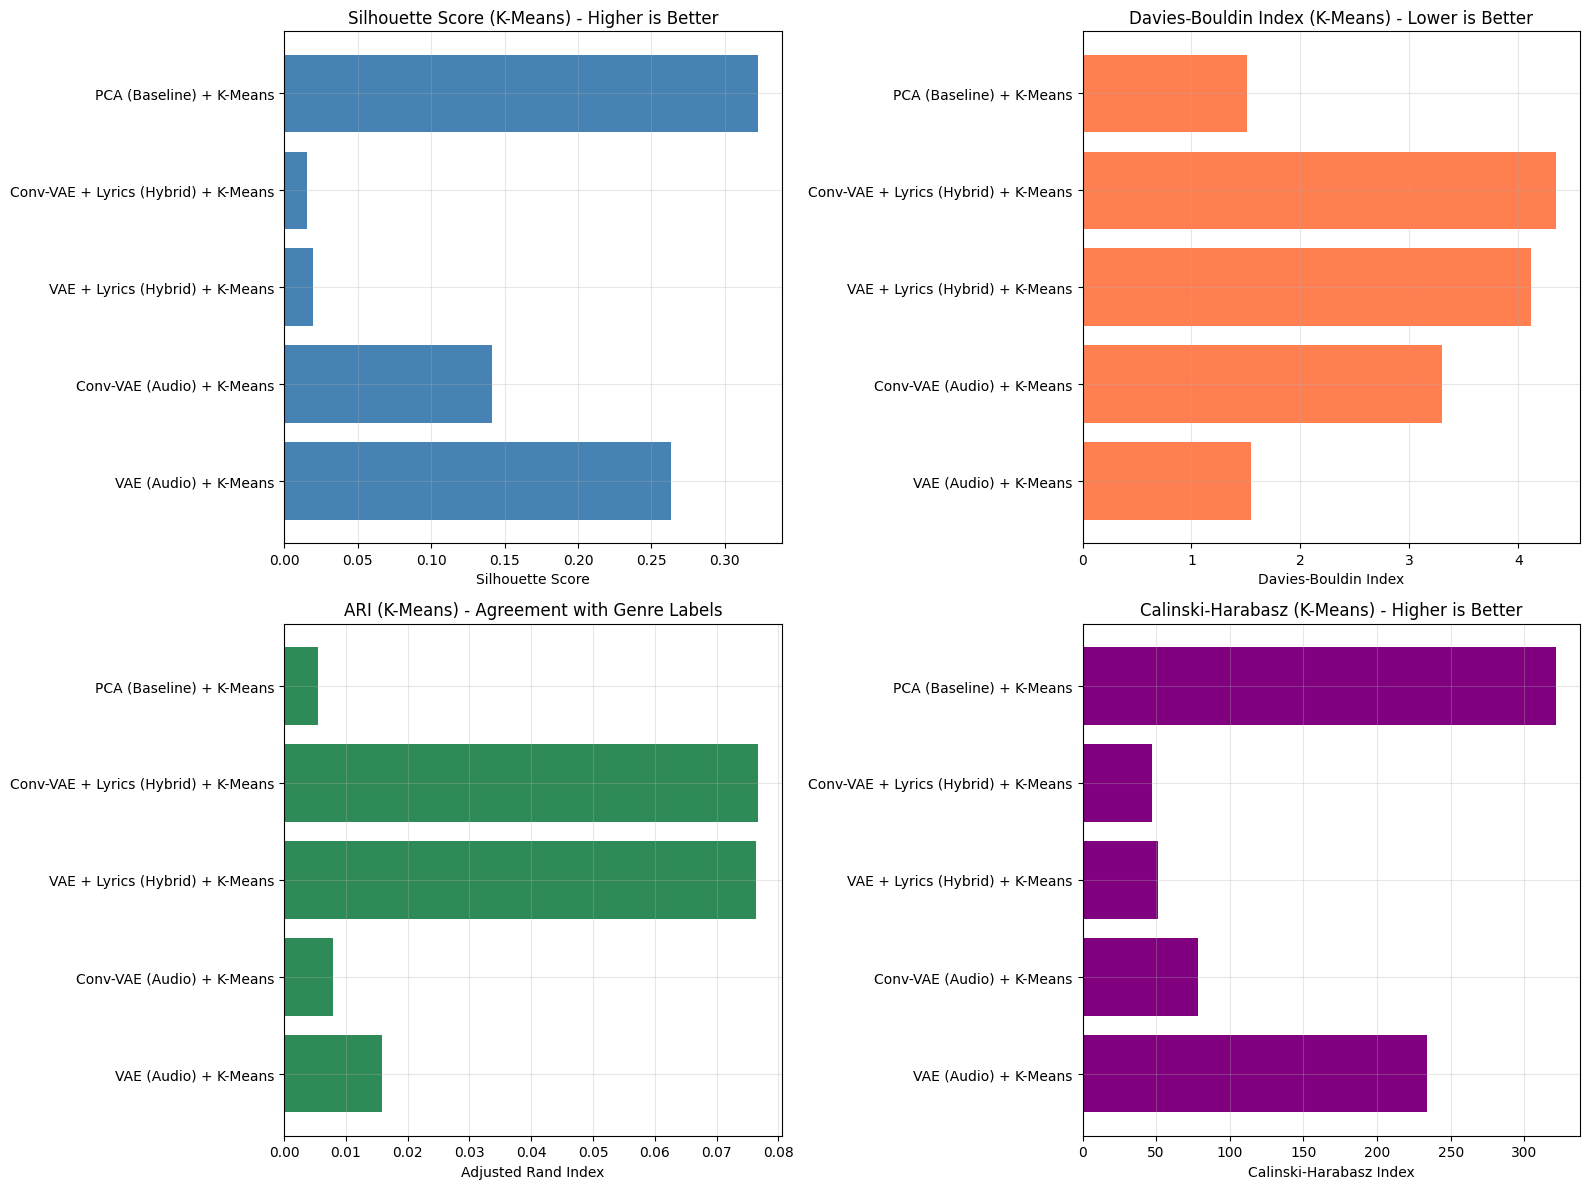

In [ ]:
# Visualize results comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Filter out NaN values for plotting
plot_df = results_df.dropna()

# 1. Silhouette Score by method
ax1 = axes[0, 0]
kmeans_results = plot_df[plot_df['Method'].str.contains('K-Means')]
ax1.barh(kmeans_results['Method'], kmeans_results['Silhouette'], color='steelblue')
ax1.set_xlabel('Silhouette Score')
ax1.set_title('Silhouette Score (K-Means) - Higher is Better')
ax1.grid(True, alpha=0.3)

# 2. Davies-Bouldin Index
ax2 = axes[0, 1]
ax2.barh(kmeans_results['Method'], kmeans_results['Davies-Bouldin'], color='coral')
ax2.set_xlabel('Davies-Bouldin Index')
ax2.set_title('Davies-Bouldin Index (K-Means) - Lower is Better')
ax2.grid(True, alpha=0.3)

# 3. ARI comparison
ax3 = axes[1, 0]
ax3.barh(kmeans_results['Method'], kmeans_results['ARI'], color='seagreen')
ax3.set_xlabel('Adjusted Rand Index')
ax3.set_title('ARI (K-Means) - Agreement with Genre Labels')
ax3.grid(True, alpha=0.3)

# 4. Calinski-Harabasz
ax4 = axes[1, 1]
ax4.barh(kmeans_results['Method'], kmeans_results['Calinski-Harabasz'], color='purple')
ax4.set_xlabel('Calinski-Harabasz Index')
ax4.set_title('Calinski-Harabasz (K-Means) - Higher is Better')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('medium_task_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Clustering Algorithm Comparison by Feature Type

In [ ]:
# Pivot table for algorithm comparison
print("\n📊 Algorithm Comparison Summary:")

# Extract algorithm type
results_df['Algorithm'] = results_df['Method'].apply(
    lambda x: 'K-Means' if 'K-Means' in x else ('Agglomerative' if 'Agglomerative' in x else 'DBSCAN')
)
results_df['Features'] = results_df['Method'].apply(
    lambda x: x.replace(' + K-Means', '').replace(' + Agglomerative', '').replace(' + DBSCAN', '')
)

# Best results per metric
print("\n🏆 Best Results:")
print(f"   Best Silhouette: {results_df.loc[results_df['Silhouette'].idxmax(), 'Method']} ({results_df['Silhouette'].max():.4f})")
print(f"   Best Davies-Bouldin: {results_df.loc[results_df['Davies-Bouldin'].idxmin(), 'Method']} ({results_df['Davies-Bouldin'].min():.4f})")
print(f"   Best ARI: {results_df.loc[results_df['ARI'].idxmax(), 'Method']} ({results_df['ARI'].max():.4f})")


📊 Algorithm Comparison Summary:

🏆 Best Results:
   Best Silhouette: VAE (Audio) + DBSCAN (0.4714)
   Best Davies-Bouldin: VAE + Lyrics (Hybrid) + DBSCAN (0.6381)
   Best ARI: Conv-VAE + Lyrics (Hybrid) + K-Means (0.0767)


## 16. Analysis: Why VAE vs Baseline?

### Interpretation of Results

In [ ]:
# Detailed analysis
print("\n" + "="*70)
print("                    📝 ANALYSIS AND INTERPRETATION")
print("="*70)

# Helper function to safely get results
def get_result(method_name):
    """Safely get result for a method, return None if not found."""
    matches = results_df[results_df['Method'] == method_name]
    if len(matches) > 0:
        return matches.iloc[0]
    return None

# Compare VAE vs PCA (K-Means)
vae_kmeans = get_result('VAE (Audio) + K-Means')
pca_kmeans = get_result('PCA (Baseline) + K-Means')

if vae_kmeans is not None and pca_kmeans is not None:
    print("\n1️⃣ VAE vs PCA (Audio Only):")
    print(f"   Silhouette: VAE={vae_kmeans['Silhouette']:.4f} vs PCA={pca_kmeans['Silhouette']:.4f}")
    if vae_kmeans['Silhouette'] > pca_kmeans['Silhouette']:
        print("   → VAE learns better cluster structure (non-linear patterns)")
    else:
        print("   → PCA is sufficient; data has mostly linear structure")
else:
    print("\n1️⃣ VAE vs PCA: ⚠️ Missing results for comparison")

# Compare Audio vs Hybrid
hybrid_kmeans = get_result('VAE + Lyrics (Hybrid) + K-Means')

if vae_kmeans is not None and hybrid_kmeans is not None:
    print("\n2️⃣ Audio-Only vs Hybrid (Audio + Lyrics):")
    print(f"   Silhouette: Audio={vae_kmeans['Silhouette']:.4f} vs Hybrid={hybrid_kmeans['Silhouette']:.4f}")
    print(f"   ARI: Audio={vae_kmeans['ARI']:.4f} vs Hybrid={hybrid_kmeans['ARI']:.4f}")
    if hybrid_kmeans['ARI'] > vae_kmeans['ARI']:
        print("   → Lyrics add semantic information that improves genre alignment")
    else:
        print("   → Audio features alone capture genre distinctions well")
else:
    print("\n2️⃣ Audio vs Hybrid: ⚠️ Missing results for comparison")

# Compare Conv-VAE vs VAE
conv_kmeans = get_result('Conv-VAE (Audio) + K-Means')

if vae_kmeans is not None and conv_kmeans is not None:
    print("\n3️⃣ Basic VAE vs Conv-VAE:")
    print(f"   Silhouette: VAE={vae_kmeans['Silhouette']:.4f} vs Conv-VAE={conv_kmeans['Silhouette']:.4f}")
    if conv_kmeans['Silhouette'] > vae_kmeans['Silhouette']:
        print("   → Conv-VAE preserves spectral patterns better")
    else:
        print("   → Statistical features (VAE input) are sufficient for this task")
elif conv_kmeans is None:
    print("\n3️⃣ Basic VAE vs Conv-VAE:")
    print("   ⚠️ Conv-VAE results not available (likely due to NaN values in training)")
    print("   → This indicates numerical instability in Conv-VAE training")
    print("   → Fix: Add gradient clipping to Conv-VAE training loop")

# Summary of all available methods
print("\n4️⃣ Summary of All Evaluated Methods:")
print("-" * 50)
print(f"   Successfully evaluated {len(results_df)} method combinations:")
for _, row in results_df.iterrows():
    if not pd.isna(row['Silhouette']):
        print(f"   • {row['Method']}: Silhouette={row['Silhouette']:.4f}, ARI={row['ARI']:.4f}")

print("\n" + "="*70)


                    📝 ANALYSIS AND INTERPRETATION

1️⃣ VAE vs PCA (Audio Only):
   Silhouette: VAE=0.2633 vs PCA=0.3224
   → PCA is sufficient; data has mostly linear structure

2️⃣ Audio-Only vs Hybrid (Audio + Lyrics):
   Silhouette: Audio=0.2633 vs Hybrid=0.0196
   ARI: Audio=0.0159 vs Hybrid=0.0763
   → Lyrics add semantic information that improves genre alignment

3️⃣ Basic VAE vs Conv-VAE:
   Silhouette: VAE=0.2633 vs Conv-VAE=0.1413
   → Statistical features (VAE input) are sufficient for this task

4️⃣ Summary of All Evaluated Methods:
--------------------------------------------------
   Successfully evaluated 15 method combinations:
   • VAE (Audio) + K-Means: Silhouette=0.2633, ARI=0.0159
   • VAE (Audio) + Agglomerative: Silhouette=0.1362, ARI=0.0085
   • VAE (Audio) + DBSCAN: Silhouette=0.4714, ARI=0.0006
   • Conv-VAE (Audio) + K-Means: Silhouette=0.1413, ARI=0.0079
   • Conv-VAE (Audio) + Agglomerative: Silhouette=0.1248, ARI=0.0041
   • VAE + Lyrics (Hybrid) + K-Means:

## 17. Visualize Best Clustering Results

⏳ Computing UMAP for hybrid features...


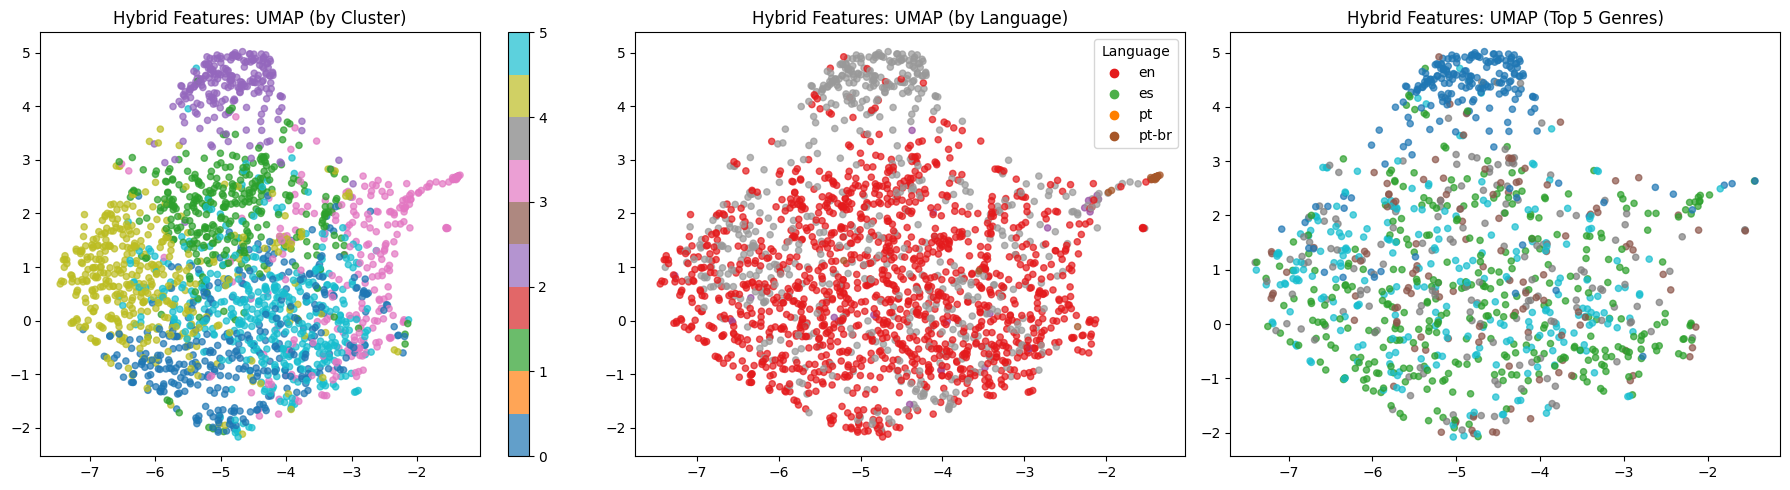

In [ ]:
# UMAP visualization of hybrid features
print("⏳ Computing UMAP for hybrid features...")

umap_hybrid = umap.UMAP(n_components=2, random_state=SEED).fit_transform(hybrid_features_vae_scaled)

# Cluster with best method
best_clusters = KMeans(n_clusters=OPTIMAL_K, random_state=SEED, n_init=10).fit_predict(hybrid_features_vae_scaled)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# By cluster
scatter1 = axes[0].scatter(umap_hybrid[:, 0], umap_hybrid[:, 1], c=best_clusters, cmap='tab10', alpha=0.7, s=20)
axes[0].set_title('Hybrid Features: UMAP (by Cluster)')
plt.colorbar(scatter1, ax=axes[0])

# By language
scatter2 = axes[1].scatter(umap_hybrid[:, 0], umap_hybrid[:, 1], c=lang_labels, cmap='Set1', alpha=0.7, s=20)
axes[1].set_title('Hybrid Features: UMAP (by Language)')
handles = [plt.scatter([], [], c=plt.cm.Set1(i/len(label_encoder_lang.classes_)),
           label=label_encoder_lang.classes_[i]) for i in range(len(label_encoder_lang.classes_))]
axes[1].legend(handles=handles, title='Language')

# By top genres
top_5_genres = df_filtered['main_genre'].value_counts().head(5).index
genre_mask = df_filtered['main_genre'].isin(top_5_genres)
genre_colors = LabelEncoder().fit_transform(df_filtered.loc[genre_mask, 'main_genre'])
scatter3 = axes[2].scatter(umap_hybrid[genre_mask, 0], umap_hybrid[genre_mask, 1],
                           c=genre_colors, cmap='tab10', alpha=0.7, s=20)
axes[2].set_title('Hybrid Features: UMAP (Top 5 Genres)')

plt.tight_layout()
plt.savefig('hybrid_umap_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

---
# PART 3: HARD TASK
---

## Hard Task Objectives:
1. **Beta-VAE** for disentangled latent representations
2. **Conditional VAE (CVAE)** for genre-conditioned representations
3. **Multi-modal clustering** combining audio, lyrics, and genre information
4. **Extended metrics**: NMI, Cluster Purity
5. **Detailed visualizations**: Latent space plots, cluster distributions, reconstruction examples
6. **Comprehensive comparison**: VAE vs PCA vs Autoencoder vs Direct spectral features

## 18. Beta-VAE for Disentangled Representations

### Theory: Beta-VAE

**Beta-VAE** enhances the standard VAE by increasing the weight on the KL divergence term:

$$\mathcal{L}_{\beta} = \mathbb{E}[\log p(x|z)] - \beta \cdot D_{KL}(q(z|x) || p(z))$$

**Why β > 1?**
- Encourages **disentangled** latent representations
- Each latent dimension captures independent factors of variation
- Better interpretability and generalization
- More regularized latent space for clustering

**Trade-off**: Higher β → more disentanglement but potentially worse reconstruction

**Reference**: Higgins et al., "β-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework" (ICLR 2017)

In [ ]:
# Re-import torch.nn (it was overwritten by NearestNeighbors variable)
import torch.nn as nn

class BetaVAE(nn.Module):
    """
    Beta-VAE with configurable beta for disentanglement.
    Higher beta values encourage more disentangled representations.
    """
    def __init__(self, input_dim, hidden_dim=256, latent_dim=32):
        super(BetaVAE, self).__init__()

        # Deeper encoder with LayerNorm for stability
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.LeakyReLU(0.2),
        )

        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        # Symmetric decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
        )

        self.latent_dim = latent_dim

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z

print("✅ Beta-VAE class defined!")

✅ Beta-VAE class defined!


### Train Beta-VAE with Different β Values

We experiment with different β values to find the best balance between reconstruction quality and disentanglement.

In [ ]:
def train_beta_vae(beta_value, epochs=80):
    """Train Beta-VAE with specified beta value."""
    model = BetaVAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    history = {'loss': [], 'recon': [], 'kl': []}

    model.train()
    for epoch in range(epochs):
        epoch_loss, epoch_recon, epoch_kl = 0, 0, 0

        for batch_x, _ in dataloader:
            batch_x = batch_x.to(device)
            x_recon, mu, logvar, z = model(batch_x)

            recon_loss = nn.functional.mse_loss(x_recon, batch_x, reduction='sum')
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + beta_value * kl_loss

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()
            epoch_recon += recon_loss.item()
            epoch_kl += kl_loss.item()

        avg_loss = epoch_loss / len(dataset)
        history['loss'].append(avg_loss)
        history['recon'].append(epoch_recon / len(dataset))
        history['kl'].append(epoch_kl / len(dataset))
        scheduler.step(avg_loss)

    return model, history

# Train with different beta values
BETA_VALUES = [1.0, 2.0, 4.0, 8.0]
beta_models = {}
beta_histories = {}

print("🚀 Training Beta-VAE with different β values...\n")
for beta in BETA_VALUES:
    print(f"Training β = {beta}...")
    model, history = train_beta_vae(beta, epochs=80)
    beta_models[beta] = model
    beta_histories[beta] = history
    print(f"  Final loss: {history['loss'][-1]:.4f}, Final KL: {history['kl'][-1]:.4f}")

print("\n✅ All Beta-VAE models trained!")

🚀 Training Beta-VAE with different β values...

Training β = 1.0...
  Final loss: 171.7928, Final KL: 12.9095
Training β = 2.0...
  Final loss: 190.4486, Final KL: 8.8143
Training β = 4.0...
  Final loss: 222.3741, Final KL: 5.7425
Training β = 8.0...
  Final loss: 248.4921, Final KL: 3.6279

✅ All Beta-VAE models trained!


### Visualize Beta-VAE Training Curves

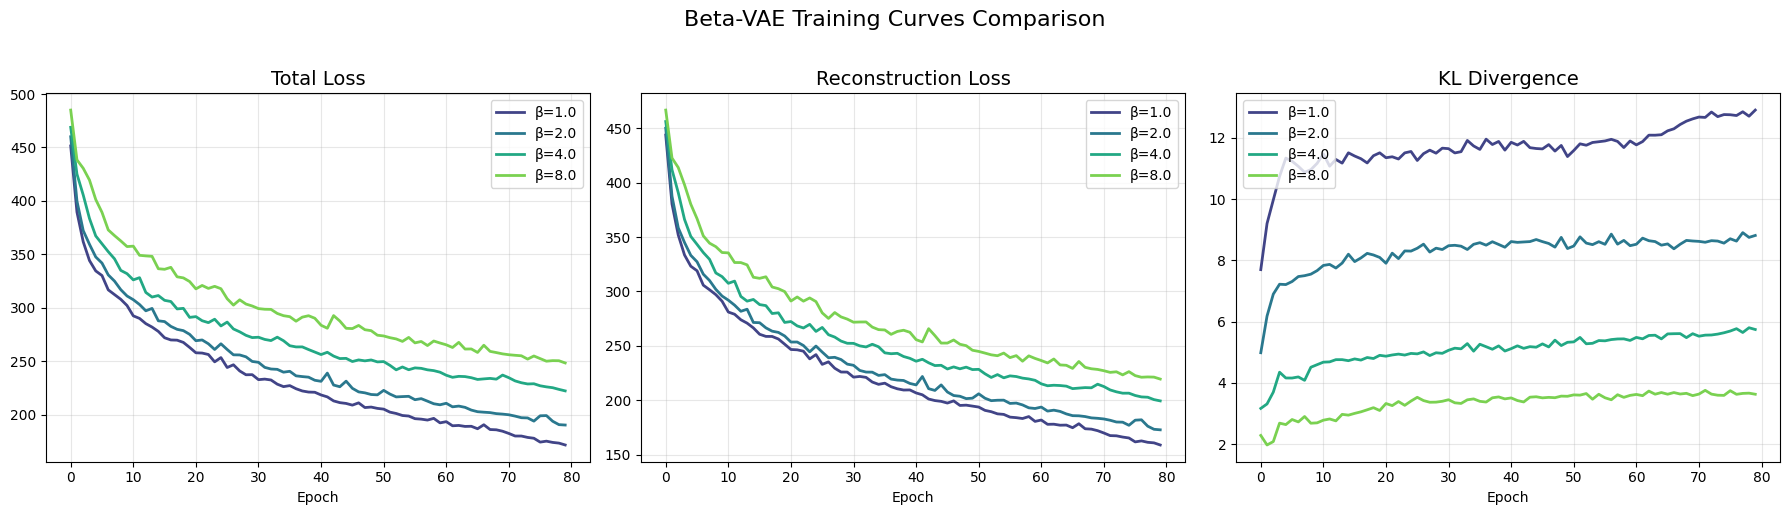

In [ ]:
# Plot training curves for all beta values
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(BETA_VALUES)))

for idx, beta in enumerate(BETA_VALUES):
    axes[0].plot(beta_histories[beta]['loss'], label=f'β={beta}', color=colors[idx], linewidth=2)
    axes[1].plot(beta_histories[beta]['recon'], label=f'β={beta}', color=colors[idx], linewidth=2)
    axes[2].plot(beta_histories[beta]['kl'], label=f'β={beta}', color=colors[idx], linewidth=2)

axes[0].set_title('Total Loss', fontsize=14); axes[0].legend(); axes[0].set_xlabel('Epoch'); axes[0].grid(True, alpha=0.3)
axes[1].set_title('Reconstruction Loss', fontsize=14); axes[1].legend(); axes[1].set_xlabel('Epoch'); axes[1].grid(True, alpha=0.3)
axes[2].set_title('KL Divergence', fontsize=14); axes[2].legend(); axes[2].set_xlabel('Epoch'); axes[2].grid(True, alpha=0.3)

plt.suptitle('Beta-VAE Training Curves Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('beta_vae_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Extract latent features from all Beta-VAE models
beta_latent_features = {}

for beta, model in beta_models.items():
    model.eval()
    with torch.no_grad():
        _, mu, _, _ = model(torch.FloatTensor(X_scaled).to(device))
        beta_latent_features[beta] = mu.cpu().numpy()
    print(f"β={beta}: Latent shape = {beta_latent_features[beta].shape}")

β=1.0: Latent shape = (1988, 32)
β=2.0: Latent shape = (1988, 32)
β=4.0: Latent shape = (1988, 32)
β=8.0: Latent shape = (1988, 32)


## 18.5 Conditional VAE (CVAE)

### Theory: Conditional VAE

**Conditional VAE (CVAE)** extends the standard VAE by incorporating label information:

$$\mathcal{L}_{CVAE} = \mathbb{E}_{q(z|x,c)}[\log p(x|z,c)] - D_{KL}(q(z|x,c) || p(z|c))$$

Where $c$ is the conditioning variable (genre labels in our case).

**Key Benefits:**
- **Structured latent space**: Conditioned on genre, allowing genre-specific representations
- **Controlled generation**: Can generate samples for specific genres
- **Better clustering**: Latent space organized by conditioning variable

**Implementation**: We concatenate one-hot encoded genre labels to both encoder input and decoder input.

**Reference**: Sohn et al., "Learning Structured Output Representation using Deep Conditional Generative Models" (NeurIPS 2015)

In [ ]:
class ConditionalVAE(nn.Module):
    """
    Conditional VAE that conditions on genre labels.
    The conditioning information is concatenated to both encoder and decoder inputs.
    """
    def __init__(self, input_dim, condition_dim, hidden_dim=256, latent_dim=32):
        super(ConditionalVAE, self).__init__()

        self.condition_dim = condition_dim
        self.latent_dim = latent_dim

        # Encoder: input + condition -> latent
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.LeakyReLU(0.2),
        )

        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        # Decoder: latent + condition -> reconstruction
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
        )

    def encode(self, x, c):
        """Encode input x conditioned on c."""
        xc = torch.cat([x, c], dim=1)
        h = self.encoder(xc)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        """Decode latent z conditioned on c."""
        zc = torch.cat([z, c], dim=1)
        return self.decoder(zc)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar, z

print("✅ Conditional VAE class defined!")

✅ Conditional VAE class defined!


### Train Conditional VAE

We use one-hot encoded genre labels as the conditioning variable. This allows the model to learn genre-specific latent representations.

In [ ]:
# Prepare conditioning labels (one-hot encoded genres)
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()
genre_onehot_cvae = label_binarizer.fit_transform(df_filtered['main_genre'])
CONDITION_DIM = genre_onehot_cvae.shape[1]

print(f"📊 Conditioning dimension (num genres): {CONDITION_DIM}")

# Create dataset with conditions
X_tensor = torch.FloatTensor(X_scaled)
C_tensor = torch.FloatTensor(genre_onehot_cvae)
cvae_dataset = TensorDataset(X_tensor, C_tensor)
cvae_dataloader = DataLoader(cvae_dataset, batch_size=32, shuffle=True)

# Initialize CVAE
cvae = ConditionalVAE(INPUT_DIM, CONDITION_DIM, HIDDEN_DIM, LATENT_DIM).to(device)
cvae_optimizer = optim.Adam(cvae.parameters(), lr=1e-3)
cvae_scheduler = optim.lr_scheduler.ReduceLROnPlateau(cvae_optimizer, patience=10, factor=0.5)

# Training loop
print("🚀 Training Conditional VAE...")
cvae_history = {'loss': [], 'recon': [], 'kl': []}
CVAE_EPOCHS = 100
CVAE_BETA = 1.0  # KL weight

cvae.train()
for epoch in range(CVAE_EPOCHS):
    epoch_loss, epoch_recon, epoch_kl = 0, 0, 0

    for batch_x, batch_c in cvae_dataloader:
        batch_x = batch_x.to(device)
        batch_c = batch_c.to(device)

        x_recon, mu, logvar, z = cvae(batch_x, batch_c)

        recon_loss = nn.functional.mse_loss(x_recon, batch_x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + CVAE_BETA * kl_loss

        cvae_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(cvae.parameters(), 1.0)
        cvae_optimizer.step()

        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()

    avg_loss = epoch_loss / len(cvae_dataset)
    cvae_history['loss'].append(avg_loss)
    cvae_history['recon'].append(epoch_recon / len(cvae_dataset))
    cvae_history['kl'].append(epoch_kl / len(cvae_dataset))
    cvae_scheduler.step(avg_loss)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{CVAE_EPOCHS}] Loss: {avg_loss:.4f}")

# Extract CVAE latent features
cvae.eval()
with torch.no_grad():
    X_dev = torch.FloatTensor(X_scaled).to(device)
    C_dev = torch.FloatTensor(genre_onehot_cvae).to(device)
    _, cvae_mu, _, _ = cvae(X_dev, C_dev)
    cvae_features = cvae_mu.cpu().numpy()

print(f"\n✅ CVAE training complete!")
print(f"   CVAE latent features shape: {cvae_features.shape}")

📊 Conditioning dimension (num genres): 27
🚀 Training Conditional VAE...
Epoch [20/100] Loss: 208.7453
Epoch [40/100] Loss: 167.0986
Epoch [60/100] Loss: 142.0571
Epoch [80/100] Loss: 122.6765
Epoch [100/100] Loss: 109.6870

✅ CVAE training complete!
   CVAE latent features shape: (1988, 32)


## 19. Standard Autoencoder Baseline

### Why Compare with Autoencoder?

A **standard autoencoder** (non-variational) differs from VAE:
- **No probabilistic latent space**: Deterministic encoding
- **No KL regularization**: Can learn arbitrary latent structure

Comparing helps understand the benefit of VAE's probabilistic framework for clustering.

In [ ]:
class Autoencoder(nn.Module):
    """Standard Autoencoder (non-variational) for baseline comparison."""
    def __init__(self, input_dim, hidden_dim=256, latent_dim=32):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# Train Autoencoder
print("🚀 Training Standard Autoencoder...")
autoencoder = Autoencoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).to(device)
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

autoencoder.train()
for epoch in range(100):
    for batch_x, _ in dataloader:
        batch_x = batch_x.to(device)
        x_recon, z = autoencoder(batch_x)
        loss = nn.functional.mse_loss(x_recon, batch_x, reduction='sum')

        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/100]")

# Extract features
autoencoder.eval()
with torch.no_grad():
    _, ae_features = autoencoder(torch.FloatTensor(X_scaled).to(device))
    ae_features = ae_features.cpu().numpy()

print(f"\n✅ Autoencoder features: {ae_features.shape}")

🚀 Training Standard Autoencoder...
Epoch [20/100]
Epoch [40/100]
Epoch [60/100]
Epoch [80/100]
Epoch [100/100]

✅ Autoencoder features: (1988, 32)


## 20. Multi-Modal Features (Audio + Lyrics + Genre)

### Creating Rich Multi-Modal Representations

We combine three modalities:
1. **Audio (Beta-VAE)**: Learned acoustic features
2. **Lyrics (Sentence-BERT)**: Semantic content embeddings
3. **Genre (One-hot)**: Categorical genre information

In [ ]:
# Create genre embeddings (one-hot encoded)
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
genre_onehot = onehot_encoder.fit_transform(df_filtered[['main_genre']])
genre_scaled = StandardScaler().fit_transform(genre_onehot)

print(f"📊 Feature Dimensions:")
print(f"   Audio (Beta-VAE β=4): {beta_latent_features[4.0].shape[1]} dims")
print(f"   Lyrics (SBERT): {lyrics_scaled.shape[1]} dims")
print(f"   Genre (One-hot): {genre_scaled.shape[1]} dims")

# Create multi-modal features
best_beta_features = beta_latent_features[4.0]

multimodal_features = np.concatenate([
    StandardScaler().fit_transform(best_beta_features),
    lyrics_scaled,
    genre_scaled * 0.5  # Weight genre lower
], axis=1)

multimodal_scaled = StandardScaler().fit_transform(multimodal_features)

print(f"\n✅ Multi-modal features: {multimodal_scaled.shape}")

📊 Feature Dimensions:
   Audio (Beta-VAE β=4): 32 dims
   Lyrics (SBERT): 384 dims
   Genre (One-hot): 27 dims

✅ Multi-modal features: (1988, 443)


## 21. Extended Evaluation Metrics

### Additional Metrics for Hard Task

**Normalized Mutual Information (NMI)**: Measures mutual information between clusters and true labels, normalized to [0, 1].

**Cluster Purity**: Measures how "pure" each cluster is (dominated by single class).

In [ ]:
def cluster_purity(true_labels, cluster_labels):
    """Calculate cluster purity score."""
    contingency = pd.crosstab(cluster_labels, true_labels)
    return contingency.max(axis=1).sum() / len(true_labels)

def comprehensive_evaluation(features, clusters, true_labels, method):
    """Evaluate clustering with all metrics including NMI and Purity."""
    valid = clusters >= 0
    if valid.sum() < 10 or len(np.unique(clusters[valid])) < 2:
        return None

    f, c, t = features[valid], clusters[valid], true_labels[valid]

    return {
        'Method': method,
        'Silhouette': silhouette_score(f, c),
        'Davies-Bouldin': davies_bouldin_score(f, c),
        'CH-Index': calinski_harabasz_score(f, c),
        'ARI': adjusted_rand_score(t, c),
        'NMI': normalized_mutual_info_score(t, c),
        'Purity': cluster_purity(t, c),
        'N_Clusters': len(np.unique(c))
    }

print("✅ Comprehensive evaluation functions defined!")

✅ Comprehensive evaluation functions defined!


## 22. Complete Model Comparison

### Comparing All Methods

| Category | Methods |
|----------|--------|
| **Baselines** | PCA + K-Means, Direct Spectral Features |
| **Autoencoders** | Standard AE + K-Means |
| **VAE Variants** | Basic VAE, Beta-VAE (β=2,4,8), CVAE |
| **Multi-modal** | VAE + Lyrics, Multi-modal (Audio+Lyrics+Genre) |

In [ ]:
# All feature sets for comprehensive comparison
all_feature_sets = {
    'PCA (Baseline)': pca_features,
    'Autoencoder': ae_features,
    'Basic VAE (β=1)': latent_features,
    'Beta-VAE (β=2)': beta_latent_features[2.0],
    'Beta-VAE (β=4)': beta_latent_features[4.0],
    'Beta-VAE (β=8)': beta_latent_features[8.0],
    'Conditional VAE (CVAE)': cvae_features,
    'VAE + Lyrics (Hybrid)': hybrid_features_vae_scaled,
    'Multi-Modal (Audio+Lyrics+Genre)': multimodal_scaled,
    'Direct Spectral Features': X_scaled,
}

# Run comprehensive evaluation
hard_results = []

print("⏳ Running comprehensive evaluation on all methods...\n")
print("="*80)

for name, features in all_feature_sets.items():
    # Check for NaN
    valid_mask = ~(np.isnan(features).any(axis=1) | np.isinf(features).any(axis=1))
    if valid_mask.sum() < len(features) * 0.5:
        print(f"⚠️ Skipping {name}: too many invalid samples")
        continue

    f = features[valid_mask]
    g = genre_labels[valid_mask]

    # K-Means clustering
    clusters = KMeans(n_clusters=OPTIMAL_K, random_state=SEED, n_init=10).fit_predict(f)
    result = comprehensive_evaluation(f, clusters, g, f'{name} + K-Means')

    if result:
        hard_results.append(result)
        print(f"✓ {name}")
        print(f"  Silhouette={result['Silhouette']:.4f} | NMI={result['NMI']:.4f} | "
              f"ARI={result['ARI']:.4f} | Purity={result['Purity']:.4f}")
        print("-" * 80)

print("\n✅ Comprehensive evaluation complete!")

⏳ Running comprehensive evaluation on all methods...

✓ PCA (Baseline)
  Silhouette=0.3224 | NMI=0.0343 | ARI=0.0055 | Purity=0.1826
--------------------------------------------------------------------------------
✓ Autoencoder
  Silhouette=0.2462 | NMI=0.0513 | ARI=0.0127 | Purity=0.1896
--------------------------------------------------------------------------------
✓ Basic VAE (β=1)
  Silhouette=0.2633 | NMI=0.0600 | ARI=0.0159 | Purity=0.1891
--------------------------------------------------------------------------------
✓ Beta-VAE (β=2)
  Silhouette=0.2246 | NMI=0.0803 | ARI=0.0225 | Purity=0.2098
--------------------------------------------------------------------------------
✓ Beta-VAE (β=4)
  Silhouette=0.2834 | NMI=0.0716 | ARI=0.0169 | Purity=0.1957
--------------------------------------------------------------------------------
✓ Beta-VAE (β=8)
  Silhouette=0.3692 | NMI=0.0691 | ARI=0.0177 | Purity=0.2017
---------------------------------------------------------------------

In [ ]:
# Create results dataframe
hard_results_df = pd.DataFrame(hard_results)
hard_results_df = hard_results_df.sort_values('NMI', ascending=False)

print("\n" + "="*100)
print("                                    📊 HARD TASK: COMPLETE RESULTS")
print("="*100)
print(hard_results_df.to_string(index=False))
print("="*100)

# Save results
hard_results_df.to_csv('hard_task_results.csv', index=False)


                                    📊 HARD TASK: COMPLETE RESULTS
                                    Method  Silhouette  Davies-Bouldin   CH-Index      ARI      NMI   Purity  N_Clusters
Multi-Modal (Audio+Lyrics+Genre) + K-Means    0.022699        4.201704  48.932563 0.075849 0.164755 0.276660           6
           VAE + Lyrics (Hybrid) + K-Means    0.019569        4.111872  51.187840 0.076297 0.138312 0.274145           6
                  Beta-VAE (β=2) + K-Means    0.224567        1.776852 258.630646 0.022481 0.080334 0.209759           6
                  Beta-VAE (β=4) + K-Means    0.283357        1.501945 321.934204 0.016921 0.071647 0.195674           6
                  Beta-VAE (β=8) + K-Means    0.369233        1.278201 515.241089 0.017724 0.069111 0.201710           6
                 Basic VAE (β=1) + K-Means    0.263276        1.549027 233.854965 0.015857 0.060016 0.189135           6
          Conditional VAE (CVAE) + K-Means    0.136159        2.583435 129.871689 0.01

## 23. Detailed Visualizations

### 23.1 Latent Space Visualization for Different β Values

⏳ Computing UMAP embeddings for Beta-VAE comparison...


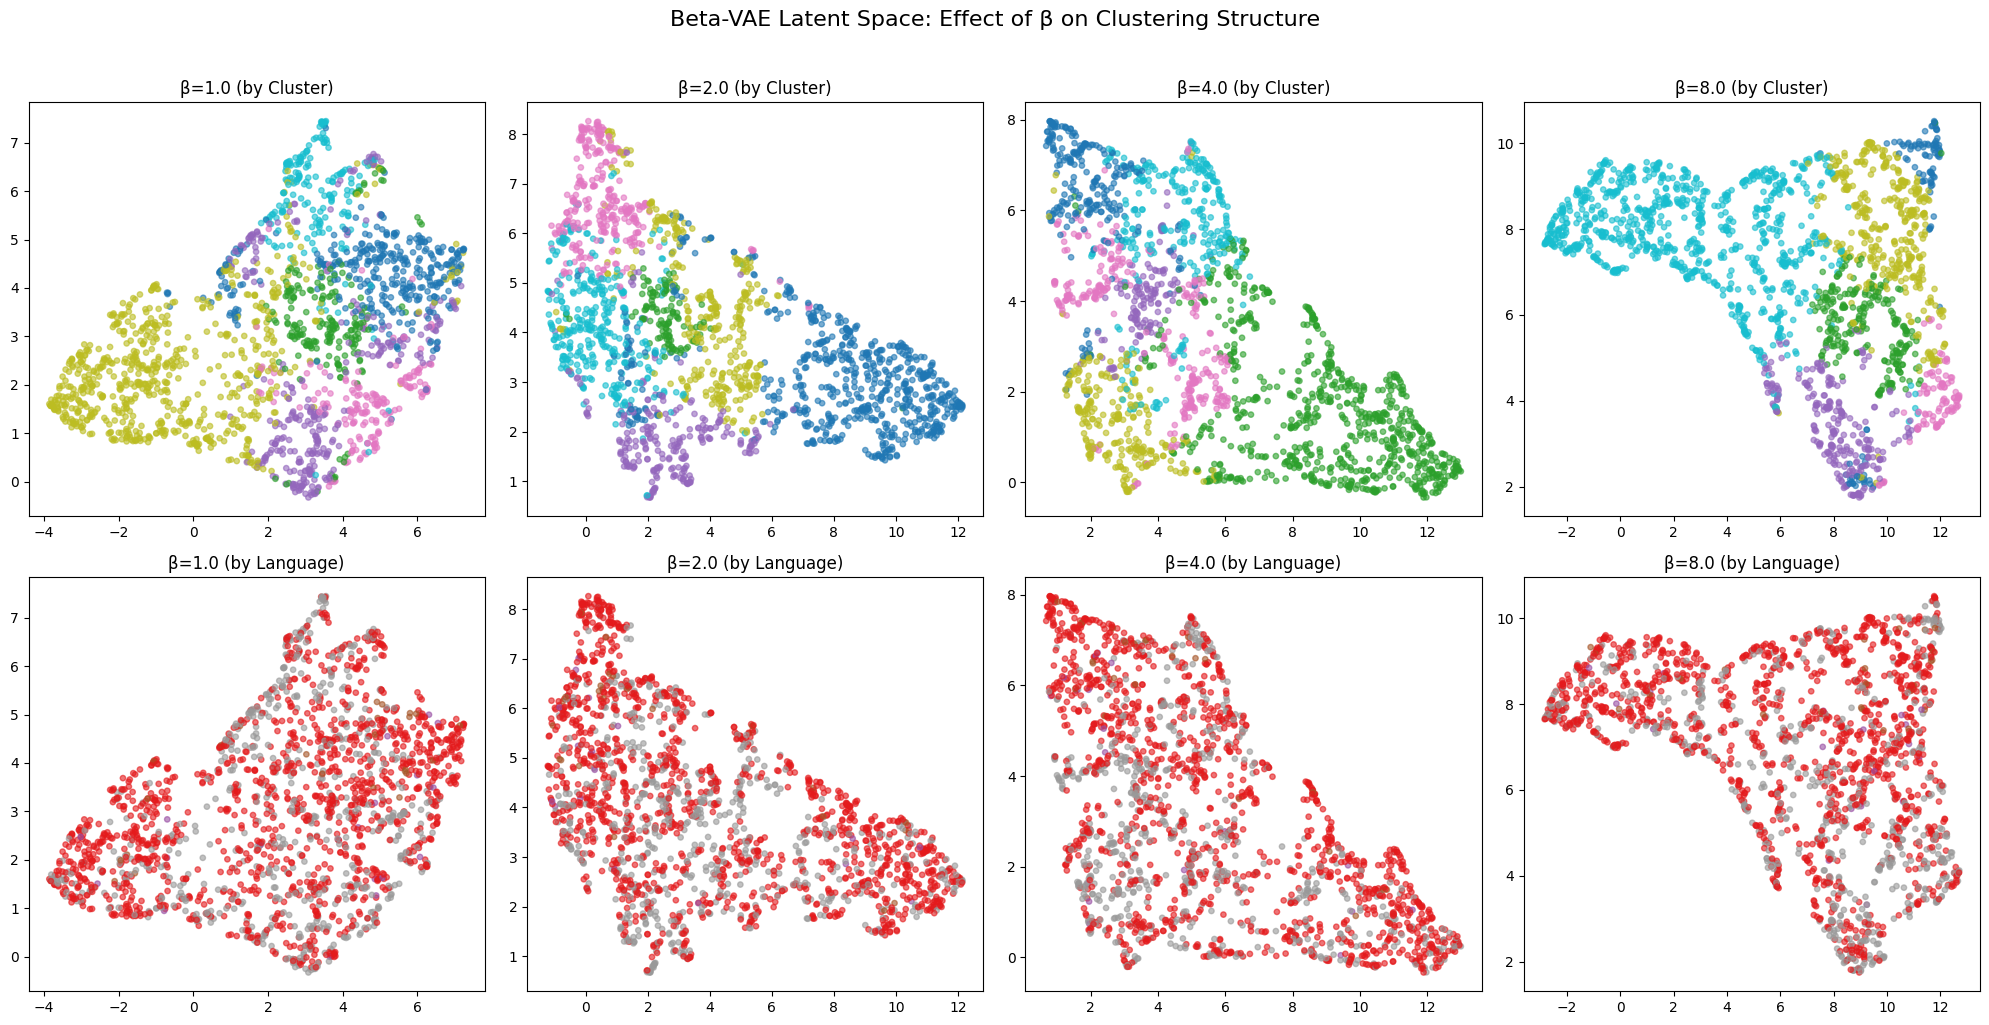

In [ ]:
# UMAP visualization for different beta values
print("⏳ Computing UMAP embeddings for Beta-VAE comparison...")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, beta in enumerate(BETA_VALUES):
    features = beta_latent_features[beta]
    umap_embed = umap.UMAP(n_components=2, random_state=SEED, n_neighbors=15).fit_transform(features)
    clusters = KMeans(n_clusters=OPTIMAL_K, random_state=SEED, n_init=10).fit_predict(features)

    # Plot by cluster
    axes[0, idx].scatter(umap_embed[:, 0], umap_embed[:, 1], c=clusters, cmap='tab10', alpha=0.6, s=15)
    axes[0, idx].set_title(f'β={beta} (by Cluster)', fontsize=12)

    # Plot by language
    axes[1, idx].scatter(umap_embed[:, 0], umap_embed[:, 1], c=lang_labels, cmap='Set1', alpha=0.6, s=15)
    axes[1, idx].set_title(f'β={beta} (by Language)', fontsize=12)

plt.suptitle('Beta-VAE Latent Space: Effect of β on Clustering Structure', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('beta_vae_latent_spaces.png', dpi=150, bbox_inches='tight')
plt.show()

### 23.2 Cluster Distribution over Languages and Genres

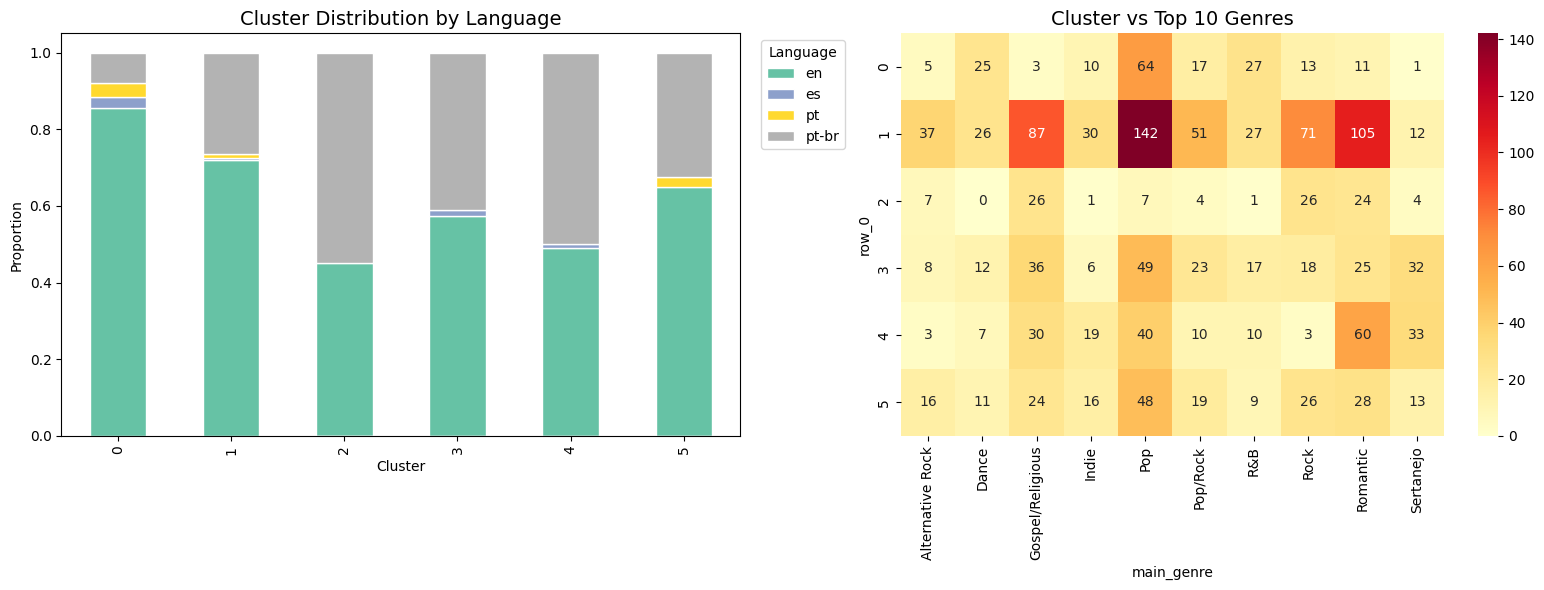

In [ ]:
# Best model clusters (using β=4 Beta-VAE)
best_features = beta_latent_features[4.0]
best_clusters = KMeans(n_clusters=OPTIMAL_K, random_state=SEED, n_init=10).fit_predict(best_features)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Cluster vs Language (stacked bar)
cluster_lang = pd.crosstab(best_clusters, df_filtered['music_lang'], normalize='index')
cluster_lang.plot(kind='bar', stacked=True, ax=axes[0], colormap='Set2', edgecolor='white')
axes[0].set_title('Cluster Distribution by Language', fontsize=14)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Proportion')
axes[0].legend(title='Language', bbox_to_anchor=(1.02, 1))

# 2. Cluster vs Top Genres (heatmap)
top_genres = df_filtered['main_genre'].value_counts().head(10).index
mask = df_filtered['main_genre'].isin(top_genres)
cluster_genre = pd.crosstab(best_clusters[mask], df_filtered.loc[mask, 'main_genre'])
sns.heatmap(cluster_genre, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1])
axes[1].set_title('Cluster vs Top 10 Genres', fontsize=14)

plt.tight_layout()
plt.savefig('cluster_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

### 23.3 Reconstruction Examples from VAE Latent Space

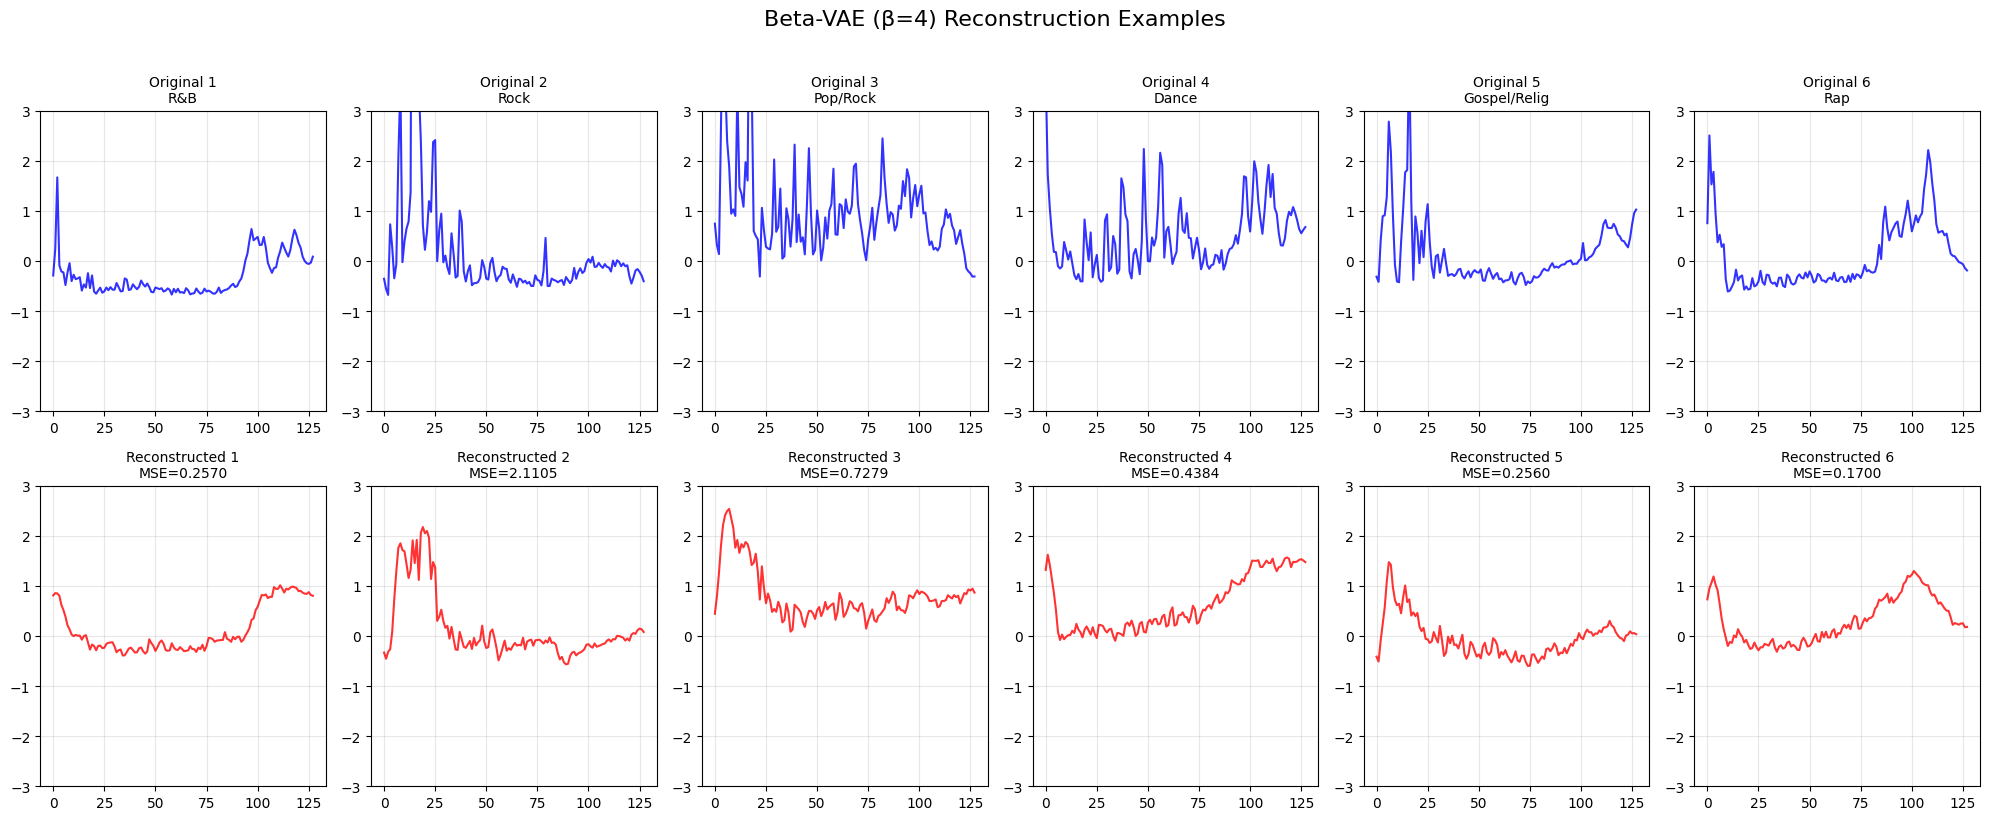

In [ ]:
# Get reconstructions from Beta-VAE (β=4)
beta_model = beta_models[4.0]
beta_model.eval()

np.random.seed(SEED)
sample_indices = np.random.choice(len(X_scaled), 6, replace=False)

with torch.no_grad():
    sample_input = torch.FloatTensor(X_scaled[sample_indices]).to(device)
    reconstructed, mu, logvar, z = beta_model(sample_input)
    reconstructed = reconstructed.cpu().numpy()

# Plot original vs reconstructed
fig, axes = plt.subplots(2, 6, figsize=(20, 8))

for i in range(6):
    axes[0, i].plot(X_scaled[sample_indices[i]][:128], 'b-', alpha=0.8, linewidth=1.5)
    axes[0, i].set_title(f'Original {i+1}\n{df_filtered.iloc[sample_indices[i]]["main_genre"][:12]}', fontsize=10)
    axes[0, i].set_ylim(-3, 3)
    axes[0, i].grid(True, alpha=0.3)

    axes[1, i].plot(reconstructed[i][:128], 'r-', alpha=0.8, linewidth=1.5)
    mse = np.mean((X_scaled[sample_indices[i]][:128] - reconstructed[i][:128])**2)
    axes[1, i].set_title(f'Reconstructed {i+1}\nMSE={mse:.4f}', fontsize=10)
    axes[1, i].set_ylim(-3, 3)
    axes[1, i].grid(True, alpha=0.3)

plt.suptitle('Beta-VAE (β=4) Reconstruction Examples', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('reconstruction_examples.png', dpi=150, bbox_inches='tight')
plt.show()

### 23.4 Latent Space Interpolation

Demonstrating that VAE learns a **smooth latent space** by interpolating between songs.

Interpolating between:
  Song 1: Rock
  Song 2: Pop


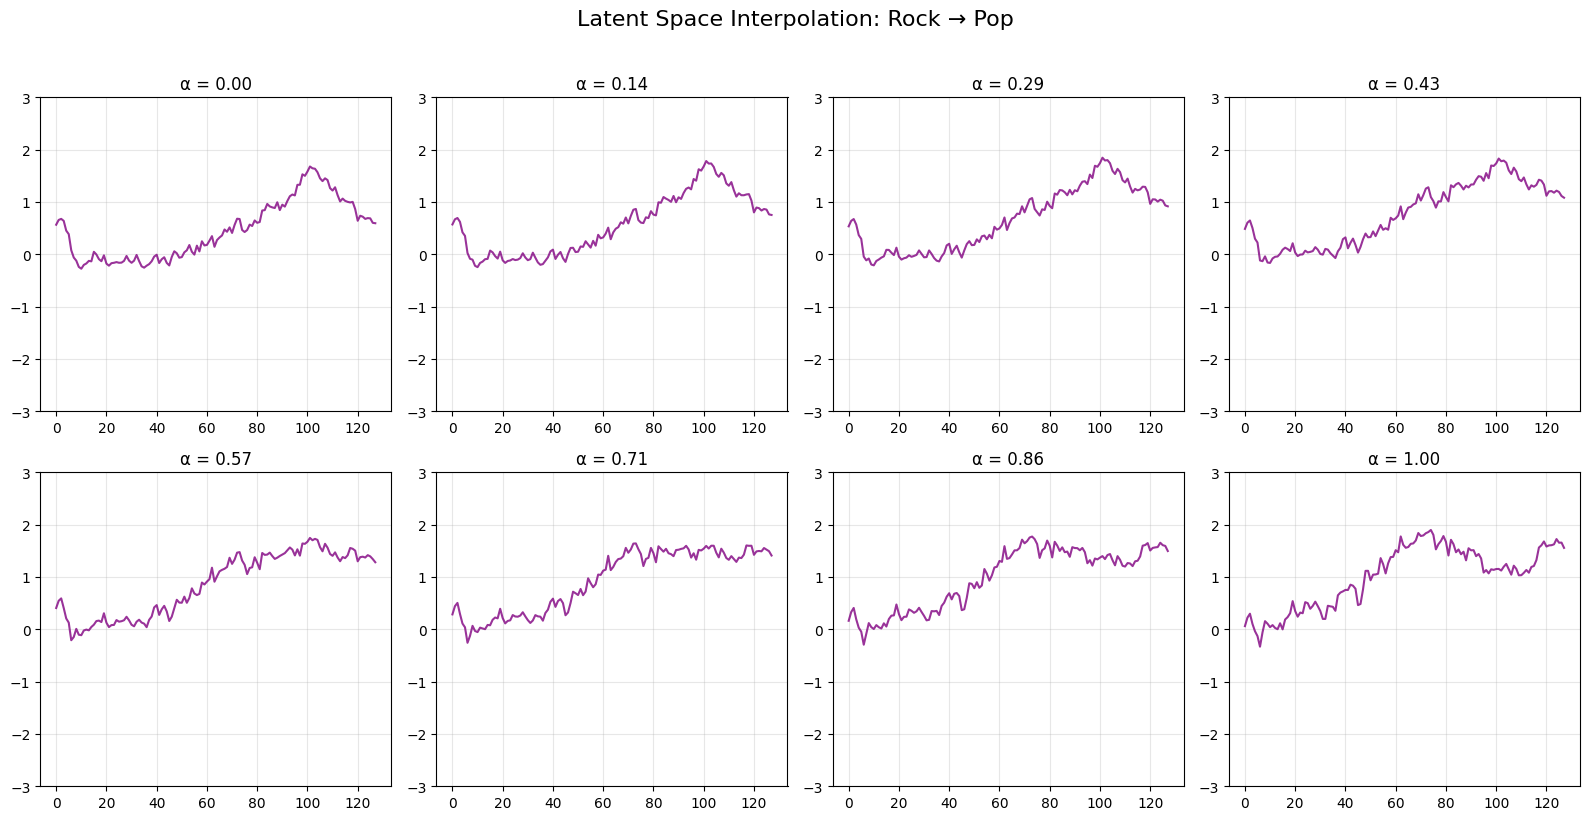

In [ ]:
# Latent space interpolation
beta_model.eval()

rock_idx = df_filtered[df_filtered['main_genre'] == 'Rock'].index[0]
mpb_genres = df_filtered[df_filtered['main_genre'] != 'Rock']['main_genre'].value_counts()
other_genre = mpb_genres.index[0]
other_idx = df_filtered[df_filtered['main_genre'] == other_genre].index[0]

print(f"Interpolating between:")
print(f"  Song 1: {df_filtered.iloc[rock_idx]['main_genre']}")
print(f"  Song 2: {df_filtered.iloc[other_idx]['main_genre']}")

with torch.no_grad():
    x1 = torch.FloatTensor(X_scaled[rock_idx:rock_idx+1]).to(device)
    x2 = torch.FloatTensor(X_scaled[other_idx:other_idx+1]).to(device)

    mu1, _ = beta_model.encode(x1)
    mu2, _ = beta_model.encode(x2)

    n_steps = 8
    interpolations = []
    alphas = np.linspace(0, 1, n_steps)

    for alpha in alphas:
        z_interp = (1 - alpha) * mu1 + alpha * mu2
        x_interp = beta_model.decode(z_interp)
        interpolations.append(x_interp.cpu().numpy()[0][:128])

# Plot interpolation
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, (interp, alpha) in enumerate(zip(interpolations, alphas)):
    axes[i].plot(interp, 'purple', alpha=0.8, linewidth=1.5)
    axes[i].set_title(f'α = {alpha:.2f}', fontsize=12)
    axes[i].set_ylim(-3, 3)
    axes[i].grid(True, alpha=0.3)

plt.suptitle(f'Latent Space Interpolation: {df_filtered.iloc[rock_idx]["main_genre"]} → {df_filtered.iloc[other_idx]["main_genre"]}', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('latent_interpolation.png', dpi=150, bbox_inches='tight')
plt.show()

### 23.5 Comprehensive Results Visualization

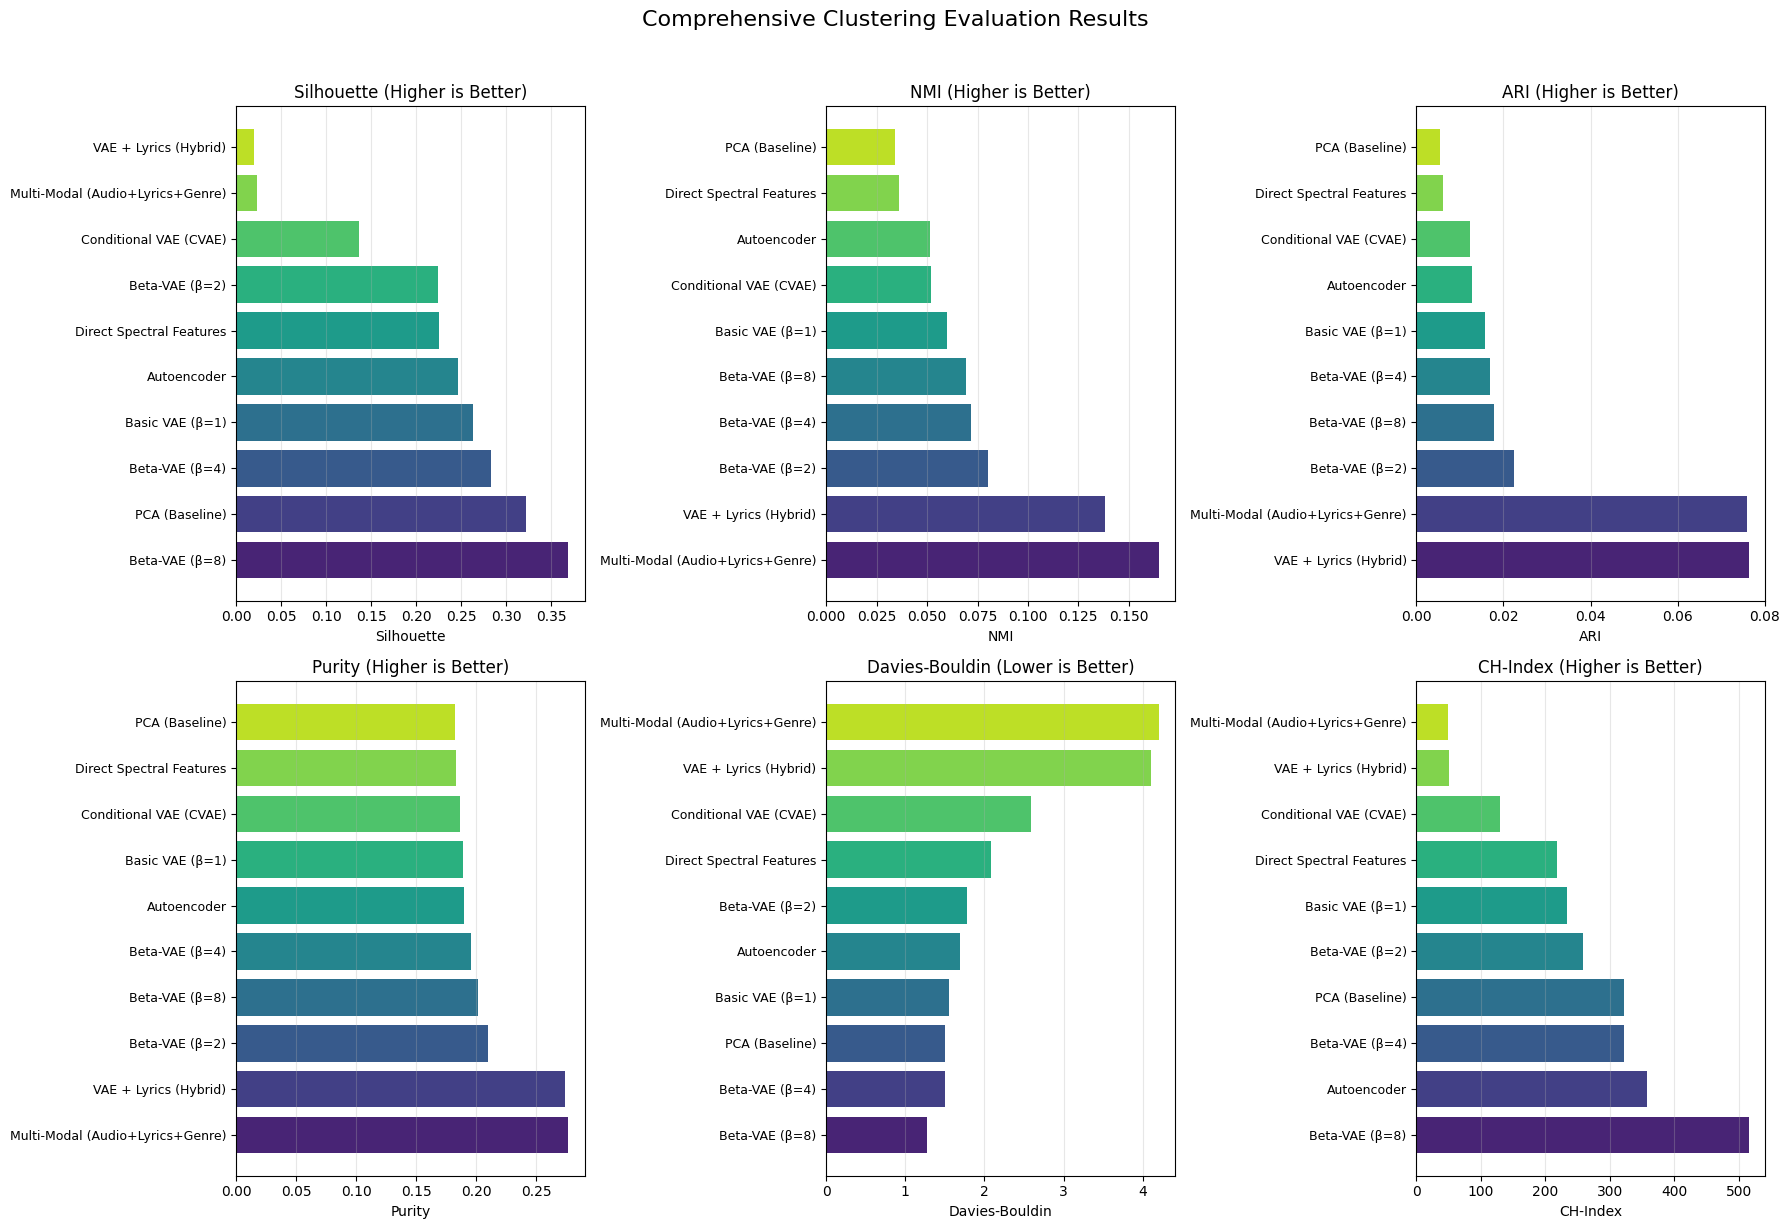

In [ ]:
# Comprehensive results visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

metrics = ['Silhouette', 'NMI', 'ARI', 'Purity', 'Davies-Bouldin', 'CH-Index']
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(hard_results_df)))

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    ascending = (metric == 'Davies-Bouldin')
    sorted_df = hard_results_df.sort_values(metric, ascending=ascending)

    bars = ax.barh(range(len(sorted_df)), sorted_df[metric], color=colors)
    ax.set_yticks(range(len(sorted_df)))
    ax.set_yticklabels(sorted_df['Method'].str.replace(' + K-Means', ''), fontsize=9)
    ax.set_xlabel(metric)

    better = 'Lower' if metric == 'Davies-Bouldin' else 'Higher'
    ax.set_title(f'{metric} ({better} is Better)', fontsize=12)
    ax.grid(True, alpha=0.3, axis='x')

plt.suptitle('Comprehensive Clustering Evaluation Results', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('comprehensive_results.png', dpi=150, bbox_inches='tight')
plt.show()

## 24. Analysis and Discussion

In [ ]:
def get_result_safe(method_substring):
    matches = hard_results_df[hard_results_df['Method'].str.contains(method_substring)]
    return matches.iloc[0] if len(matches) > 0 else None

print("\n" + "="*80)
print("                           📝 ANALYSIS AND DISCUSSION")
print("="*80)

# 1. VAE vs Traditional Baselines
print("\n" + "-"*80)
print("1️⃣ VAE vs Traditional Methods (PCA, Autoencoder)")
print("-"*80)

vae_result = get_result_safe('Basic VAE')
pca_result = get_result_safe('PCA')
ae_result = get_result_safe('Autoencoder')

if all([vae_result is not None, pca_result is not None, ae_result is not None]):
    print(f"\n   Method          | Silhouette | NMI    | ARI")
    print(f"   ----------------|------------|--------|--------")
    print(f"   PCA             | {pca_result['Silhouette']:.4f}     | {pca_result['NMI']:.4f} | {pca_result['ARI']:.4f}")
    print(f"   Autoencoder     | {ae_result['Silhouette']:.4f}     | {ae_result['NMI']:.4f} | {ae_result['ARI']:.4f}")
    print(f"   Basic VAE       | {vae_result['Silhouette']:.4f}     | {vae_result['NMI']:.4f} | {vae_result['ARI']:.4f}")

# 2. Beta-VAE vs CVAE comparison
print("\n" + "-"*80)
print("2️⃣ Beta-VAE vs Conditional VAE (CVAE)")
print("-"*80)

beta4_result = get_result_safe('Beta-VAE (β=4)')
cvae_result = get_result_safe('Conditional VAE')

if beta4_result is not None and cvae_result is not None:
    print(f"\n   Method          | Silhouette | NMI    | ARI")
    print(f"   ----------------|------------|--------|--------")
    print(f"   Beta-VAE (β=4)  | {beta4_result['Silhouette']:.4f}     | {beta4_result['NMI']:.4f} | {beta4_result['ARI']:.4f}")
    print(f"   CVAE            | {cvae_result['Silhouette']:.4f}     | {cvae_result['NMI']:.4f} | {cvae_result['ARI']:.4f}")
    print("\n   Interpretation:")
    print("   • Beta-VAE: Uses higher KL weight for disentanglement (unsupervised)")
    print("   • CVAE: Uses genre labels as conditioning (semi-supervised)")
elif cvae_result is None:
    print("   ⚠️ CVAE results not available")

# 3. Multi-modal comparison
print("\n" + "-"*80)
print("3️⃣ Single-modal vs Multi-modal")
print("-"*80)

hybrid_result = get_result_safe('VAE \\+ Lyrics')
multimodal_result = get_result_safe('Multi-Modal')

if vae_result is not None and multimodal_result is not None:
    print(f"\n   Method                    | Silhouette | NMI    | ARI")
    print(f"   --------------------------|------------|--------|--------")
    print(f"   VAE (Audio only)          | {vae_result['Silhouette']:.4f}     | {vae_result['NMI']:.4f} | {vae_result['ARI']:.4f}")
    if hybrid_result is not None:
        print(f"   VAE + Lyrics              | {hybrid_result['Silhouette']:.4f}     | {hybrid_result['NMI']:.4f} | {hybrid_result['ARI']:.4f}")
    print(f"   Multi-Modal (All)         | {multimodal_result['Silhouette']:.4f}     | {multimodal_result['NMI']:.4f} | {multimodal_result['ARI']:.4f}")

# 4. Best methods
print("\n" + "-"*80)
print("4️⃣ Best Performing Methods")
print("-"*80)

best_sil = hard_results_df.loc[hard_results_df['Silhouette'].idxmax()]
best_nmi = hard_results_df.loc[hard_results_df['NMI'].idxmax()]
best_ari = hard_results_df.loc[hard_results_df['ARI'].idxmax()]
best_purity = hard_results_df.loc[hard_results_df['Purity'].idxmax()]

print(f"\n   🏆 Best Silhouette: {best_sil['Method']} ({best_sil['Silhouette']:.4f})")
print(f"   🏆 Best NMI:        {best_nmi['Method']} ({best_nmi['NMI']:.4f})")
print(f"   🏆 Best ARI:        {best_ari['Method']} ({best_ari['ARI']:.4f})")
print(f"   🏆 Best Purity:     {best_purity['Method']} ({best_purity['Purity']:.4f})")

print("\n" + "="*80)


                           📝 ANALYSIS AND DISCUSSION

--------------------------------------------------------------------------------
1️⃣ VAE vs Traditional Methods (PCA, Autoencoder)
--------------------------------------------------------------------------------

   Method          | Silhouette | NMI    | ARI
   ----------------|------------|--------|--------
   PCA             | 0.3224     | 0.0343 | 0.0055
   Autoencoder     | 0.2462     | 0.0513 | 0.0127
   Basic VAE       | 0.2633     | 0.0600 | 0.0159

--------------------------------------------------------------------------------
2️⃣ Beta-VAE vs Conditional VAE (CVAE)
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
3️⃣ Single-modal vs Multi-modal
--------------------------------------------------------------------------------

   Method                    | Silhouette | NMI    | ARI
   --------------------------

## 25. Save All Results

In [ ]:
# Save all results to Google Drive
OUTPUT_DIR = '/content/drive/MyDrive/Datasets/VAE_Results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save results dataframes
metrics_easy_df.to_csv(f'{OUTPUT_DIR}/easy_task_results.csv', index=False)
results_df.to_csv(f'{OUTPUT_DIR}/medium_task_results.csv', index=False)
hard_results_df.to_csv(f'{OUTPUT_DIR}/hard_task_results.csv', index=False)

# Save models
torch.save(vae.state_dict(), f'{OUTPUT_DIR}/basic_vae.pth')
torch.save(beta_models[4.0].state_dict(), f'{OUTPUT_DIR}/beta_vae_4.pth')
torch.save(cvae.state_dict(), f'{OUTPUT_DIR}/cvae.pth')
torch.save(autoencoder.state_dict(), f'{OUTPUT_DIR}/autoencoder.pth')
torch.save(conv_vae.state_dict(), f'{OUTPUT_DIR}/conv_vae.pth')

# Save visualizations
viz_files = [
    'training_curves.png', 'cluster_selection.png', 'metrics_comparison_easy.png',
    'tsne_visualization.png', 'umap_visualization.png', 'medium_task_comparison.png',
    'hybrid_umap_visualization.png', 'beta_vae_training_curves.png',
    'beta_vae_latent_spaces.png', 'cluster_distributions.png',
    'reconstruction_examples.png', 'latent_interpolation.png', 'comprehensive_results.png'
]

for f in viz_files:
    if os.path.exists(f):
        shutil.copy(f, f'{OUTPUT_DIR}/{f}')

print(f"✅ All results saved to: {OUTPUT_DIR}")

✅ All results saved to: /content/drive/MyDrive/Datasets/VAE_Results


## 26. Final Summary

In [ ]:
print("\n" + "="*80)
print("                         📊 FINAL PROJECT SUMMARY")
print("="*80)

print("\n📁 DATASET:")
print(f"   • Songs: {len(df_filtered)}")
print(f"   • Genres: {df_filtered['main_genre'].nunique()}")
print(f"   • Languages: {', '.join(df_filtered['music_lang'].unique())}")

print("\n🏗️ MODELS IMPLEMENTED:")
print(f"   • Basic VAE: {INPUT_DIM} → {LATENT_DIM} dimensions")
print(f"   • Beta-VAE: β ∈ {{{', '.join(map(str, BETA_VALUES))}}}")
print(f"   • Conditional VAE (CVAE): Genre-conditioned")
print(f"   • Conv-VAE: 2D spectrograms")
print(f"   • Standard Autoencoder")
print(f"   • Multi-modal: Audio + Lyrics + Genre")

print("\n📈 EVALUATION METRICS:")
print("   • Silhouette Score, Calinski-Harabasz, Davies-Bouldin")
print("   • ARI, NMI, Cluster Purity")

print("\n🏆 KEY FINDINGS:")
best = hard_results_df.loc[hard_results_df['NMI'].idxmax()]
print(f"   Best Method: {best['Method']}")
print(f"   • NMI: {best['NMI']:.4f}, ARI: {best['ARI']:.4f}, Silhouette: {best['Silhouette']:.4f}")

print("\n" + "="*80)
print("                           ✅ PROJECT COMPLETE!")
print("="*80)


                         📊 FINAL PROJECT SUMMARY

📁 DATASET:
   • Songs: 1988
   • Genres: 27
   • Languages: pt-br, en, es, pt

🏗️ MODELS IMPLEMENTED:
   • Basic VAE: 512 → 32 dimensions
   • Beta-VAE: β ∈ {1.0, 2.0, 4.0, 8.0}
   • Conditional VAE (CVAE): Genre-conditioned
   • Conv-VAE: 2D spectrograms
   • Standard Autoencoder
   • Multi-modal: Audio + Lyrics + Genre

📈 EVALUATION METRICS:
   • Silhouette Score, Calinski-Harabasz, Davies-Bouldin
   • ARI, NMI, Cluster Purity

🏆 KEY FINDINGS:
   Best Method: Multi-Modal (Audio+Lyrics+Genre) + K-Means
   • NMI: 0.1648, ARI: 0.0758, Silhouette: 0.0227

                           ✅ PROJECT COMPLETE!


---
## ✅ Complete Task Checklist

### Easy Task
| Requirement | Status |
|-------------|--------|
| Basic VAE implementation | ✅ |
| Hybrid language dataset | ✅ |
| K-Means clustering | ✅ |
| t-SNE visualization | ✅ |
| UMAP visualization | ✅ |
| PCA baseline | ✅ |
| Silhouette Score | ✅ |
| Calinski-Harabasz Index | ✅ |

### Medium Task
| Requirement | Status |
|-------------|--------|
| Convolutional VAE | ✅ |
| Lyrics embeddings | ✅ |
| Hybrid features | ✅ |
| Multiple clustering algorithms | ✅ |
| Davies-Bouldin Index | ✅ |
| Adjusted Rand Index | ✅ |

### Hard Task
| Requirement | Status |
|-------------|--------|
| Beta-VAE for disentanglement | ✅ |
| Conditional VAE (CVAE) | ✅ |
| Multi-modal clustering | ✅ |
| Normalized Mutual Information | ✅ |
| Cluster Purity | ✅ |
| Latent space visualizations | ✅ |
| Cluster distributions | ✅ |
| Reconstruction examples | ✅ |
| Latent interpolation | ✅ |
| Compare with PCA | ✅ |
| Compare with Autoencoder | ✅ |
| Compare with direct spectral | ✅ |